In [1]:
import numpy as np
import random as rd
import pandas as pd
import math

import statsmodels.formula.api as sm
import chart_studio.plotly as py

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib notebook

import ipywidgets as widgets

from IPython.display import display, Markdown

#### Obtención de datasets

In [2]:
def get_pds():
    url = 'https://drive.google.com/file/d/1NulAOMTMRPDzsfh9-DBMdiiPlKQWZoEH/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
    pk = pd.read_csv(path)
    pk.rename(columns = {'Name':'Nombre', 'Species':'Especie', 'Variant':'Variante', 'Generation':'Generación', 'Rarity':'Rareza',
                        'Evolves_from':'Evoluciona de', 'Has_gender_diff':'Diferencia_género', 'Type1':'Tipo1', 'Type2':'Tipo2',
                        'HP':'Vida', 'Attack':'Ataque', 'Defense':'Defensa', 'Sp. Atk': 'Ataque_esp', 'Sp. Def':'Defensa_esp',
                        'Speed':'Velocidad', 'VGC2022_rules': 'Permiso VGC2022'}, inplace = True)

    ## Información sobre los distintos movimientos, tipo de ataque, tipo de daño, presición, etc.
    url = 'https://drive.google.com/file/d/10bN4zif5RYgSEtNByuorwvWnvqWmSKgv/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
    moves = pd.read_csv(path)

    ## Información sobre la naturaleza del Pokemon y como afecta las estadísticas del mismo (incrementa o decrementa cada stat en 10%)
    url = 'https://drive.google.com/file/d/1af9KS4H6NkTCMPJBvXx70j9TDk12cfk9/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
    nat = pd.read_csv(path)
    
    ## Información sobre pokemones utilizados en conjunto en el mismo equipo
    url = 'https://drive.google.com/file/d/194RGr9hAuo3QTsg01Dnyw2MCAoBNeEvz/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
    pwp = pd.read_csv(path)
    pwp.rename(columns = {'Use_Percentage (%)':'Uso(%)', 'Pokemon':'Pokemon', 'Teammate':'Compañero'}, inplace = True)
    pwp['Uso(%)'] = pwp['Uso(%)'].apply(lambda x: x.replace("%", ""))
    pwp = pwp.astype({'Uso(%)': 'float64'})
    
    ## Efectividad de tipos
    url = 'https://drive.google.com/file/d/1MeRyRnwszQlp1HZegznslQash2pCAdcX/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
    eff = pd.read_csv(path)
    eff["Effectiveness"] = eff["Effectiveness"].apply(lambda x: 1 if str(x).find('Normal') != -1 else (0.5 if str(x).find('Not very') != -1 else 2))
    
    ## Movimientos que puede aprender un Pokemon
    url = 'https://drive.google.com/file/d/1sbpvpGnUYM6p4tJcWT3qEqyWUCZyvDNs/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
    m_learn = pd.read_csv(path)
    
    ## Muestra de combates
    url = 'https://drive.google.com/file/d/1LQh3I3j8QXzzeiV0Is6oFauyi708Y7Ke/view?usp=sharing'
    #url = 'https://drive.google.com/file/d/1-bSOlq7FKFfo50qgMsOKlgJbJK862c0P/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
    wins = pd.read_csv(path)
    wins = wins.drop(columns=['Unnamed: 0'])
    
    return pk, moves, nat, pwp, eff, m_learn, wins

#### Adecuación de datos

In [3]:
def get_ganadores_stats(wins, pk):
    ganadores = wins.groupby('Winner').count()
    ganadores = ganadores.drop(columns=['First_pokemon'])
    ganadores.rename(columns = {'Second_pokemon':'Victorias'}, inplace = True)

    # Dado que el dataframe original diferencia entre quienes atacaron primero se calculan las victorias cuando atacó primero
    # las victorias cuando atacó segundo, y luego se suman

    combates_primeratk = wins.groupby('First_pokemon').count()
    combates_primeratk = combates_primeratk.drop(columns=['Second_pokemon'])
    combates_primeratk.rename(columns = {'Winner':'Combates'}, inplace = True)

    combates_segatk = wins.groupby('Second_pokemon').count()
    combates_segatk = combates_segatk.drop(columns=['First_pokemon'])
    combates_segatk.rename(columns = {'Winner':'Combates'}, inplace = True)

    # Existe un Pokemon que no ganó batallas y para evitar problemas con las longitudes se agrega manualmente.
    df2 = pd.DataFrame([0], columns=list(['Victorias']), index=['Shuckle'])
    ganadores = ganadores.append(df2).sort_index()

    ganadores['Combates'] = combates_primeratk['Combates'] + combates_segatk['Combates']
    ganadores['Porcentaje_victoria'] = ganadores['Victorias'] / ganadores['Combates']

    ganadores = ganadores.merge(pk[['Nombre', 'Ataque', 'Ataque_esp', 'Defensa', 'Defensa_esp', 'Velocidad', 'Vida']], how='left',left_index=True, right_on=['Nombre'])
    ganadores = ganadores.set_index('Nombre')
    
    return ganadores

def get_ganadores_difstats(wins, pk):
    wins2 = wins.copy()

    def return_loser(winner, first, second):
        if winner == second:
            return first
        else:
            return second

    wins2['Loser'] = wins2.apply(lambda x: return_loser(x['Winner'], x['First_pokemon'], x['Second_pokemon']), axis=1)

    wins2 = wins2.drop(columns = ['First_pokemon', 'Second_pokemon'])

    wins2 = wins2.merge(pk[['Nombre', 'Ataque', 'Ataque_esp', 'Defensa', 'Defensa_esp', 'Velocidad', 'Vida']], how='left',left_on=['Winner'], right_on=['Nombre'])
    wins2 = wins2.merge(pk[['Nombre', 'Ataque', 'Ataque_esp', 'Defensa', 'Defensa_esp', 'Velocidad', 'Vida']], how='left',left_on=['Loser'], right_on=['Nombre'], suffixes=('_w','_l'))
    wins2 = wins2.drop(columns = ['Nombre_l', 'Nombre_w']) 
    wins2['Ataque_dif'] = wins2['Ataque_w'] - wins2['Ataque_l']
    wins2['Ataque_esp_dif'] = wins2['Ataque_esp_w'] - wins2['Ataque_esp_l']
    wins2['Defensa_dif'] = wins2['Defensa_w'] - wins2['Defensa_l']
    wins2['Defensa_esp_dif'] = wins2['Defensa_esp_w'] - wins2['Defensa_esp_l']
    wins2['Velocidad_dif'] = wins2['Velocidad_w'] - wins2['Velocidad_l']
    wins2['Vida_dif'] = wins2['Vida_w'] - wins2['Vida_l']
    
    return wins2

def unique_sorted_values(array):
    unique = array.unique().tolist()
    unique.sort()
    return unique

def unique_sorted_values_plus_NONE(array):
    NONE = 'NONE'
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, NONE)
    return unique

def get_natur(pk_stats, nat_tmp, nat):
    if (nat == 'NONE'):
            pk_stats_nat = pk_stats.copy()
    else:
        pk_stats_nat = pk_stats.copy()
        if (nat_tmp.loc[nat]['Increases'] == 'Attack'):
            pk_stats_nat['Ataque'] = pk_stats_nat['Ataque'].apply(lambda x: x*1.1)
        elif (nat_tmp.loc[nat]['Increases'] == 'Sp. Atk'):
            pk_stats_nat['Ataque_especial'] = pk_stats_nat['Ataque_especial'].apply(lambda x: x*1.1)
        elif (nat_tmp.loc[nat]['Increases'] == 'Defense'):
            pk_stats_nat['Defensa'] = pk_stats_nat['Defensa'].apply(lambda x: x*1.1)
        elif (nat_tmp.loc[nat]['Increases'] == 'Sp. Def'):
            pk_stats_nat['Defensa_especial'] = pk_stats_nat['Defensa_especial'].apply(lambda x: x*1.1)
        elif (nat_tmp.loc[nat]['Increases'] == 'Speed'):
            pk_stats_nat['Velocidad'] = pk_stats_nat['Velocidad'].apply(lambda x: x*1.1)

        if (nat_tmp.loc[nat]['Decreases'] == 'Attack'):
            pk_stats_nat['Ataque'] = pk_stats_nat['Ataque'].apply(lambda x: x*0.9)
        elif (nat_tmp.loc[nat]['Decreases'] == 'Sp. Atk'):
            pk_stats_nat['Ataque_especial'] = pk_stats_nat['Ataque_especial'].apply(lambda x: x*0.9)
        elif (nat_tmp.loc[nat]['Decreases'] == 'Defense'):
            pk_stats_nat['Defensa'] = pk_stats_nat['Defensa'].apply(lambda x: x*0.9)
        elif (nat_tmp.loc[nat]['Decreases'] == 'Sp. Def'):
            pk_stats_nat['Defensa_especial'] = pk_stats_nat['Defensa_especial'].apply(lambda x: x*0.9)
        elif (nat_tmp.loc[nat]['Decreases'] == 'Speed'):
            pk_stats_nat['Velocidad'] = pk_stats_nat['Velocidad'].apply(lambda x: x*0.9)
    
    return pk_stats_nat

#### EDA, visualizaciones y herramientas

In [4]:
def graph_radarchart (pk, nat):
    
    pk_stats = pd.DataFrame().assign(Nombre = pk['Nombre'], Ataque = pk['Ataque'], Defensa = pk['Defensa'], Ataque_especial = pk['Ataque_esp'],
                                 Defensa_especial = pk['Defensa_esp'], Velocidad = pk['Velocidad'])
    pk_stats = pk_stats.set_index('Nombre')
    pk_stats_nat = pk_stats

    nat_tmp = nat
    nat_tmp = nat_tmp.set_index('Nature')

    pok_r = widgets.Dropdown(options = unique_sorted_values(pk['Nombre']), description='Pokemon (rojo):', style={'description_width': 'initial'})
    natur_r = widgets.Dropdown(options = unique_sorted_values_plus_NONE(nat['Nature']), description='Naturaleza (rojo):', style={'description_width': 'initial'})

    pok_a = widgets.Dropdown(options = unique_sorted_values(pk['Nombre']), description='Pokemon (azul):', style={'description_width': 'initial'})
    natur_a = widgets.Dropdown(options = unique_sorted_values_plus_NONE(nat['Nature']), description='Naturaleza (azul):', style={'description_width': 'initial'})

    left_box = widgets.VBox([pok_r, natur_r])
    right_box = widgets.VBox([pok_a, natur_a])
    box = widgets.HBox([left_box, right_box])

    display(box)

    labels = ['Ataque', 'Defensa', 'Ataque especial', 'Defensa especial', 'Velocidad']
    # ax = plt.subplot(polar=True)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    def dropdown_eventhandler(change):
        ax.cla()
        
        sns.set_style("dark")
        pok1 = pok_r.value
        pok2 = pok_a.value
        
        nat1 = natur_r.value
        nat2 = natur_a.value
        
        pk1_stats_nat = get_natur(pk_stats, nat_tmp, nat1)
        pk2_stats_nat = get_natur(pk_stats, nat_tmp, nat2)

        # Numero de variables a plot.
        num_vars = len(labels)

        # Dividir el circulo en partes iguales y sacar los angulos 
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

        # Poner los labels
        ax.set_thetagrids(np.degrees(angles), labels)

        values_r = pk1_stats_nat.loc[pok1].values.tolist()
        values_a = pk2_stats_nat.loc[pok2].values.tolist()

        # Completar el loop y agregar el primer valor al ultimo
        values_r += values_r[:1]
        values_a += values_a[:1]
        angles += angles[:1]

        # Grafiar los datos
        ax.plot(angles, values_r, color='red', linewidth=1)
        ax.plot(angles, values_a, color='blue', linewidth=1)

        # LLenarlos
        ax.fill(angles, values_r, color='red', alpha=0.25)
        ax.fill(angles, values_a, color='blue', alpha=0.25)

        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        ax.set_rmax(250)

    pok_r.observe(dropdown_eventhandler, names='value')
    natur_r.observe(dropdown_eventhandler, names='value')

    pok_a.observe(dropdown_eventhandler, names='value')
    natur_a.observe(dropdown_eventhandler, names='value')
    
def get_boxplot(pk):
    
    sns.set_style("dark")
    
    f, (ax1, ax2) = plt.subplots(2, 2, figsize=[10, 10])

    sma = sns.boxplot(data=pk, x="Tipo1", y="Ataque", hue="Tipo1", ax = ax1[0], dodge=False)
    sma.set(xlabel ="Tipo", ylabel = "Ataque", title ='Variación de valor de ataque por tipo')
    sma.legend([],[], frameon=False)

    sma = sns.boxplot(data=pk, x="Tipo1", y="Ataque_esp", hue="Tipo1", ax = ax2[0], dodge=False)
    sma.set(xlabel ="Tipo", ylabel = "Ataque especial", title ='Variación de valor de ataque especial por tipo')
    sma.legend([],[], frameon=False)

    sma = sns.boxplot(data=pk, x="Tipo1", y="Defensa", hue="Tipo1", ax = ax1[1], dodge=False)
    sma.set(xlabel ="Tipo", ylabel = "Defensa", title ='Variación de valor de Defensa por tipo')
    sma.legend([],[], frameon=False)

    sma = sns.boxplot(data=pk, x="Tipo1", y="Defensa_esp", hue="Tipo1", ax = ax2[1], dodge=False)
    sma.set(xlabel ="Tipo", ylabel = "Defensa especial", title ='Variación de valor de Defensa especial por tipo')
    sma.legend([],[], frameon=False)

    plt.setp(ax1[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax2[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax1[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax2[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    f.tight_layout()
    plt.show()
    
def get_heatmap(pk):
    
    sns.set_style("dark")
    
    f, ax3 = plt.subplots(figsize=[8, 6])

    pk[['Tipo2']] = pk[['Tipo2']].fillna('Nada')

    pk_group = pk.groupby(['Tipo1', 'Tipo2'], as_index = False).count()

    tipos = pk_group.pivot("Tipo1", "Tipo2", "Nombre")
    tipos = tipos.fillna(0)

    sma = sns.heatmap(tipos, fmt="f", linewidths=.2, cmap="BuPu")
    sma.set(xlabel ="Tipo 2", ylabel = "Tipo 1", title ='Cantidad de Pokemons con cada combinación de tipos - Seaborn')

    plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    f.tight_layout()
    plt.show()
    
def eda_disp_tipo(pk):
    pk_stats = pd.DataFrame().assign(Nombre = pk['Tipo1'], Ataque = pk['Ataque'], Defensa = pk['Defensa'], Ataque_especial = pk['Ataque_esp'],
                                 Defensa_especial = pk['Defensa_esp'], Velocidad = pk['Velocidad'])
    
    tipo = widgets.Dropdown(options = unique_sorted_values(pk['Tipo1']), description='Tipo:', style={'description_width': 'initial'})
    display(tipo)
    
    f, ax4 = plt.subplots(2, 1, figsize=[8, 10])
    
    def dropdown_eventhandler_tipo(change):
        ax4[0].cla()
        ax4[1].cla()
        
        sns.set_style("dark")
        
        sma = sns.scatterplot(data=pk[pk['Tipo1'] == change.new], x="Ataque", y="Defensa", hue="Generación", ax = ax4[0], palette="Set1")
        sma.set(xlabel ="Ataque", ylabel = "Defensa", title ='Valor de ataque/defensa por tipo')

        sma = sns.scatterplot(data=pk[pk['Tipo1'] == change.new], x="Ataque_esp", y="Defensa_esp", hue="Generación", ax = ax4[1], palette="Set1")
        sma.set(xlabel ="Ataque especial", ylabel = "Defensa especial", title ='Valor de ataque especial/defensa especial por tipo')
        
    tipo.observe(dropdown_eventhandler_tipo, names='value')
    
def get_companero(pwp):    
    pok = widgets.Dropdown(options = unique_sorted_values(pwp['Pokemon']), description='Pokemon:', style={'description_width': 'initial'})
    display(pok)
    
    f, ax5 = plt.subplots(1, 1, figsize=[8, 4])
    
    def dropdown_eventhandler_pok(change):
        ax5.cla()
        
        sns.set_style("dark")
        
        sma = sns.barplot(data=pwp[pwp['Pokemon'] == change.new], x="Compañero", y="Uso(%)", ax = ax5, palette="Set1")
        sma.set(xlabel ="Pokemon", ylabel = "Porcentaje de casos", title ='Frecuencia de compañeros de equipo')
        
        for label in (ax5.get_xticklabels()):
            label.set_fontsize(7)
        plt.setp(ax5.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")
       
    pok.observe(dropdown_eventhandler_pok, names='value')
    
def create_team(pk, pwp):
    pok1 = widgets.Dropdown(options = unique_sorted_values(pk['Nombre']), description='Pokemon:', style={'description_width': 'initial'})

    out = widgets.Output(layout={'border': '1px solid black'})
    display(pok1, out)

    def dropdown_eventhandler_team(change):
        out.clear_output()
        pwp_aux = pwp.copy()
        
        poke = change.new
        
        with out:
            if (poke in pwp_aux['Pokemon'].values):                
                print("El equipo probable para " + poke + " es:")
                poke_team = poke
                for i in range(5):
                    pwp_tmp = pwp_aux[pwp_aux['Pokemon'] == poke_team]
                    poke_team_df = pwp_tmp[pwp_tmp['Uso(%)'] == pwp_tmp['Uso(%)'].max()]
                    poke_team = poke_team_df.iloc[0]['Compañero']
                    pwp_aux = pwp_aux[(pwp_aux['Compañero'] != poke_team)]
                    print(poke_team)
            else:
                print('No hay información sobre este Pokemon')

    pok1.observe(dropdown_eventhandler_team, names='value')
    
def eda_dispz_est(ganadores): 
    
    ganadores_z = pd.DataFrame()
    for j in ganadores.columns[1:]:
        ganadores_z[j] = (ganadores[j] - ganadores[j].mean()) / ganadores[j].std()
    
    ganadores_z['Ataque_x']= ganadores_z['Ataque'].apply(lambda x: 'Atipico' if (x>1.5 or x<-1.5) else 'Normal')
    ganadores_z['Ataque_esp_x']= ganadores_z['Ataque_esp'].apply(lambda x: 'Atipico' if (x>1.5 or x<-1.5) else 'Normal')
    ganadores_z['Defensa_x']= ganadores_z['Defensa'].apply(lambda x: 'Atipico' if (x>1.5 or x<-1.5) else 'Normal')
    ganadores_z['Defensa_esp_x']= ganadores_z['Defensa_esp'].apply(lambda x: 'Atipico' if (x>1.5 or x<-1.5) else 'Normal')
    ganadores_z['Velocidad_x']= ganadores_z['Velocidad'].apply(lambda x: 'Atipico' if (x>1.5 or x<-1.5) else 'Normal')
    ganadores_z['Vida_x']= ganadores_z['Vida'].apply(lambda x: 'Atipico' if (x>1.5 or x<-1.5) else 'Normal')

    f1, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=[10, 13])
    
    sns.set(font_scale=0.7)
    sns.set_style("dark")

    sma = sns.scatterplot(x=ganadores_z['Porcentaje_victoria'], y= ganadores_z['Ataque'], hue= ganadores_z['Ataque_x'], s= 5, ax = ax1[0])
    sma.set(xlabel ="Porcentaje de victoria", ylabel = "Ataque", title ='Porcentaje de victoria según valor de ataque')

    sma = sns.scatterplot(x=ganadores_z['Porcentaje_victoria'], y= ganadores_z['Ataque_esp'], hue= ganadores_z['Ataque_esp_x'], s= 5, ax = ax1[1])
    sma.set(xlabel ="Porcentaje de victoria", ylabel = "Ataque especial", title ='Porcentaje de victoria según valor de ataque especial')

    sma = sns.scatterplot(x=ganadores_z['Porcentaje_victoria'], y= ganadores_z['Defensa'], hue= ganadores_z['Defensa_x'], s= 5, ax = ax2[0])
    sma.set(xlabel ="Porcentaje de victoria", ylabel = "Defensa", title ='Porcentaje de victoria según valor de defensa')

    sma = sns.scatterplot(x=ganadores_z['Porcentaje_victoria'], y= ganadores_z['Defensa_esp'], hue= ganadores_z['Defensa_esp_x'], s= 5, ax = ax2[1])
    sma.set(xlabel ="Porcentaje de victoria", ylabel = "Defensa especial", title ='Porcentaje de victoria según valor de defensa especial')

    sma = sns.scatterplot(x=ganadores_z['Porcentaje_victoria'], y= ganadores_z['Velocidad'], hue= ganadores_z['Velocidad_x'], s= 5, ax = ax3[0])
    sma.set(xlabel ="Porcentaje de victoria", ylabel = "Velocidad", title ='Porcentaje de victoria según valor de velocidad')

    sma = sns.scatterplot(x=ganadores_z['Porcentaje_victoria'], y= ganadores_z['Vida'], hue= ganadores_z['Vida_x'], s= 5, ax = ax3[1])
    sma.set(xlabel ="Porcentaje de victoria", ylabel = "Vida", title ='Porcentaje de victoria según valor de vidal')
    
def eda_corrheat(ganadores):
    sns.set_style("dark")
    sns.set(font_scale=0.6)
    
    f2 = plt.figure(figsize = (8, 8))
    sns.heatmap(data=ganadores.corr(), cmap="BuPu")
    
def eda_histdif(ganadores_dif):
    
    sns.set_style("dark")
    
    f2, (ax4, ax5, ax6) = plt.subplots(3, 2, figsize=[10, 13])
    
    sma = sns.histplot(data=ganadores_dif, x="Ataque_dif", ax = ax4[0])
    sma.set(xlabel ="Diferencia de ataque", ylabel = "Cantidad", title ='Histograma de diferencia de ataque')
    
    sma = sns.histplot(data=ganadores_dif, x="Defensa_dif", ax = ax4[1])
    sma.set(xlabel ="Diferencia de defensa", ylabel = "Cantidad", title ='Histograma de diferencia de defesa')
    
    sma = sns.histplot(data=ganadores_dif, x="Ataque_esp_dif", ax = ax5[0])
    sma.set(xlabel ="Diferencia de ataque especial", ylabel = "Cantidad", title ='Histograma de diferencia de ataque especial')
    
    sma = sns.histplot(data=ganadores_dif, x="Defensa_esp_dif", ax = ax5[1])
    sma.set(xlabel ="Diferencia de defensa especial", ylabel = "Cantidad", title ='Histograma de diferencia de defensa especial')
    
    sma = sns.histplot(data=ganadores_dif, x="Velocidad_dif", ax = ax6[0])
    sma.set(xlabel ="Diferencia de velocidad", ylabel = "Cantidad", title ='Histograma de diferencia de velocidad')
    
    sma = sns.histplot(data=ganadores_dif, x="Vida_dif", ax = ax6[1])
    sma.set(xlabel ="Diferencia de vida", ylabel = "Cantidad", title ='Histograma de diferencia de vida')
    
def eda_est(pk):
    f, ax = plt.subplots(2, figsize=[8, 10])

    sma = sns.histplot(data=pk, x="Ataque", color="skyblue", label="Ataque", hue="Tipo1", bins = int(max(pk['Ataque'])), ax = ax[0], multiple="stack")
    sma.set(xlabel ="Valor de ataque", ylabel = "Cantidad de registros", title ='Cantidad de Pokemon por valor de ataque')
    sma = sns.histplot(data=pk, x="Ataque_esp", color="skyblue", label="Ataque especial", hue="Tipo1", bins = int(max(pk['Ataque_esp'])), ax = ax[1], multiple="stack")
    sma.set(xlabel ="Valor de ataque especial", ylabel = "Cantidad de registros", title ='Cantidad de Pokemon por valor de ataque especial')

    f.tight_layout()
    plt.show()

#### Modelado

In [5]:
## Cálculo de regresiones lineales de cada carácterística vs. el porcentaje de victoria
def r_square(ganadores):
    
    ## Se repite para cada característica.
    ## Cálculo de modelo de regresión lineal
    model1 = 'Ataque~Porcentaje_victoria'
    lm1 = sm.ols(formula = model1, data = ganadores).fit()
    ## Visualización de datos obtenidos con el cálculo del modelo
    print(lm1.summary())
    print('..........................................................................')
    print('                                                                          ')
    print('                                                                          ')
    print('                                                                          ')
    print('..........................................................................')

    model2 = 'Defensa~Porcentaje_victoria'
    lm2 = sm.ols(formula = model2, data = ganadores).fit()
    print(lm2.summary())
    print('..........................................................................')
    print('                                                                          ')
    print('                                                                          ')
    print('                                                                          ')
    print('..........................................................................')

    model3 = 'Ataque_esp~Porcentaje_victoria'
    lm3 = sm.ols(formula = model3, data = ganadores).fit()
    print(lm3.summary())
    print('..........................................................................')
    print('                                                                          ')
    print('                                                                          ')
    print('                                                                          ')
    print('..........................................................................')

    model4 = 'Defensa_esp~Porcentaje_victoria'
    lm4 = sm.ols(formula = model4, data = ganadores).fit()
    print(lm4.summary())
    print('..........................................................................')
    print('                                                                          ')
    print('                                                                          ')
    print('                                                                          ')
    print('..........................................................................')

    model5 = 'Velocidad~Porcentaje_victoria'
    lm5 = sm.ols(formula = model5, data = ganadores).fit()
    print(lm5.summary())
    print('..........................................................................')
    print('                                                                          ')
    print('                                                                          ')
    print('                                                                          ')
    print('..........................................................................')

    model6 = 'Vida~Porcentaje_victoria'
    lm6 = sm.ols(formula = model6, data = ganadores).fit()
    print(lm6.summary())
    
def dec_tree(ganadores_dif):
    
    ## Se crean dos dataframes temporales
    pima1 = pd.DataFrame()
    pima2 = pd.DataFrame()
    
    ## Se asigna a un dataset la lista de ganadores, las características asociadas a cada Pokemon y una columna con 1
    ## para indicar que son los ganadores
    pima1['Pokemon'] = ganadores_dif['Winner']
    pima1['Ataque'] = ganadores_dif['Ataque_w']
    pima1['Defensa'] = ganadores_dif['Defensa_w']
    pima1['Ataque_esp'] = ganadores_dif['Ataque_esp_w']
    pima1['Defensa_esp'] = ganadores_dif['Defensa_esp_w']
    pima1['Velocidad'] = ganadores_dif['Velocidad_w']
    pima1['Vida'] = ganadores_dif['Vida_w']
    pima1['label'] = 1
    
    ## Se asigna al otro dataset la lista de perdedores, las características asociadas a cada Pokemon y una columna con 0
    ## para indicar que son los perdedores
    pima2['Pokemon'] = ganadores_dif['Loser']
    pima2['Ataque'] = ganadores_dif['Ataque_l']
    pima2['Defensa'] = ganadores_dif['Defensa_l']
    pima2['Ataque_esp'] = ganadores_dif['Ataque_esp_l']
    pima2['Defensa_esp'] = ganadores_dif['Defensa_esp_l']
    pima2['Velocidad'] = ganadores_dif['Velocidad_l']
    pima2['Vida'] = ganadores_dif['Vida_l']
    pima2['label'] = 0
    
    ## Se unen los dos datasets temporales para crear el dataset que se utilizará en el modelo
    pima = pima1.append(pima2)
    
    ## Se definen las variables independientes (feature, X) y la variabla dependiente (label, y)
    feature_cols = ['Ataque', 'Defensa', 'Ataque_esp', 'Defensa_esp','Velocidad','Vida']
    X = pima[feature_cols] # Features
    y = pima.label # Target variable
    label = str(y.unique())
    
    ## Se divide el dataset, 70% para entrenamiento y 30% para testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    ## Se crea el árbol de decisión 
    clf = DecisionTreeClassifier(max_depth =5)

    ## Se entrena el árbol
    clf = clf.fit(X_train,y_train)

    ## Se evalúa la predicción para el modelo
    y_pred = clf.predict(X_test)
    
    ## Se grafica el árbol
    f = plt.figure(figsize=(25,10))
    a = tree.plot_tree(clf, feature_names = feature_cols, rounded = True, filled = True, fontsize=5, proportion = True)
    plt.show()
    
    ## Se imprime la precisión del modelo comparando los datos reservados para testing y los datos predecidos
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    metrics.plot_confusion_matrix(clf, X_test, y_test, display_labels=['Negative', 'Positive'])
    print(metrics.classification_report(y_test, y_pred))
    
def dec_tree_dif(ganadores_dif):
    ## Se crean dos dataframes temporales y dos series, una llena de 1 y otra de 0
    pima1 = pd.DataFrame()
    pima2 = pd.DataFrame()
    pima1_sp = pd.DataFrame()
    pima2_sp = pd.DataFrame()
    ones = np.ones(len(ganadores_dif['Winner'].loc[ganadores_dif['win_class'] == 'Physical']))
    zeros = np.zeros(len(ganadores_dif['Loser'].loc[ganadores_dif['win_class'] == 'Physical']))
    ones_sp = np.ones(len(ganadores_dif['Winner'].loc[ganadores_dif['win_class'] == 'Special']))
    zeros_sp = np.zeros(len(ganadores_dif['Loser'].loc[ganadores_dif['win_class'] == 'Special']))
    
    ## Se asigna a un dataset la lista de ganadores, las características asociadas a cada Pokemon y una columna con 1
    ## para indicar que son los ganadores
    pima1['Pokemon'] = ganadores_dif['Winner'].loc[ganadores_dif['win_class'] == 'Physical']
    pima1_sp['Pokemon'] = ganadores_dif['Winner'].loc[ganadores_dif['win_class'] == 'Special']
    pima1['Ataque'] = ganadores_dif['Ataque_w'].loc[ganadores_dif['win_class'] == 'Physical']
    pima1['Defensa'] = ganadores_dif['Defensa_w'].loc[ganadores_dif['win_class'] == 'Physical']
    pima1_sp['Ataque esp'] = ganadores_dif['Ataque_esp_w'].loc[ganadores_dif['win_class'] == 'Special']
    pima1_sp['Defensaesp'] = ganadores_dif['Defensa_esp_w'].loc[ganadores_dif['win_class'] == 'Special']
    pima1['Velocidad'] = ganadores_dif['Velocidad_w'].loc[ganadores_dif['win_class'] == 'Physical']
    pima1_sp['Velocidad'] = ganadores_dif['Velocidad_w'].loc[ganadores_dif['win_class'] == 'Special']
    pima1['Vida'] = ganadores_dif['Vida_w'].loc[ganadores_dif['win_class'] == 'Physical']
    pima1_sp['Vida'] = ganadores_dif['Vida_w'].loc[ganadores_dif['win_class'] == 'Special']
    pima1['label'] = ones
    pima1_sp['label'] = ones_sp
    
    ## Se asigna al otro dataset la lista de perdedores, las características asociadas a cada Pokemon y una columna con 0
    ## para indicar que son los perdedores
    pima2['Pokemon'] = ganadores_dif['Loser'].loc[ganadores_dif['win_class'] == 'Physical']
    pima2_sp['Pokemon'] = ganadores_dif['Loser'].loc[ganadores_dif['win_class'] == 'Special']
    pima2['Ataque'] = ganadores_dif['Ataque_l'].loc[ganadores_dif['win_class'] == 'Physical']
    pima2['Defensa'] = ganadores_dif['Defensa_l'].loc[ganadores_dif['win_class'] == 'Physical']
    pima2_sp['Ataque esp'] = ganadores_dif['Ataque_esp_l'].loc[ganadores_dif['win_class'] == 'Special']
    pima2_sp['Defensaesp'] = ganadores_dif['Defensa_esp_l'].loc[ganadores_dif['win_class'] == 'Special']
    pima2['Velocidad'] = ganadores_dif['Velocidad_l'].loc[ganadores_dif['win_class'] == 'Physical']
    pima2_sp['Velocidad'] = ganadores_dif['Velocidad_l'].loc[ganadores_dif['win_class'] == 'Special']
    pima2['Vida'] = ganadores_dif['Vida_l'].loc[ganadores_dif['win_class'] == 'Physical']
    pima2_sp['Vida'] = ganadores_dif['Vida_l'].loc[ganadores_dif['win_class'] == 'Special']
    pima2['label'] = zeros
    pima2_sp['label'] = zeros_sp
    
    ## Se unen los dos datasets temporales para crear el dataset que se utilizará en el modelo
    pima = pima1.append(pima2)
    pima_sp = pima1_sp.append(pima2_sp)
    
    ## Se definen las variables independientes (feature, X) y la variabla dependiente (label, y)
    feature_cols = ['Ataque', 'Defensa','Velocidad','Vida']
    feature_cols_sp = ['Ataque_esp', 'Defensa_esp','Velocidad','Vida']
    X = pima[feature_cols] # Features
    X_sp = pima_sp[feature_cols_sp] # Features
    y = pima.label # Target variable
    y_sp = pima_sp.label # Target variable
    label = str(y.unique())
    
    ## Se divide el dataset, 70% para entrenamiento y 30% para testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(X_sp, y_sp, test_size=0.3, random_state=1)
    
    ## Se crea el árbol de decisión 
    clf = DecisionTreeClassifier(max_depth =5)
    clf_sp = DecisionTreeClassifier(max_depth =5)

    ## Se entrena el árbol
    clf = clf.fit(X_train,y_train)
    clf_sp = clf.fit(X_train_sp,y_train_sp)

    ## Se evalúa la predicción para el modelo
    y_pred = clf.predict(X_test)
    y_pred_sp = clf_sp.predict(X_test_sp)
    
    ## Se grafica el árbol
    f = plt.figure(figsize=(20,10))
    a = tree.plot_tree(clf, feature_names = feature_cols, rounded = True, filled = True, fontsize=5, proportion = True)
    plt.show()
    
    f2 = plt.figure(figsize=(20,10))
    a = tree.plot_tree(clf_sp, feature_names = feature_cols_sp, rounded = True, filled = True, fontsize=5, proportion = True)
    plt.show()
    
    ## Se imprime la precisión del modelo comparando los datos reservados para testing y los datos predecidos
    print("Precisión para ataque físico:",metrics.accuracy_score(y_test, y_pred))
    print("Precisión para ataque especial:",metrics.accuracy_score(y_test_sp, y_pred_sp))
    
    metrics.plot_confusion_matrix(clf, X_test, y_test, display_labels=['Negative', 'Positive'])
    print(metrics.classification_report(y_test, y_pred))
    
    metrics.plot_confusion_matrix(clf_sp, X_test_sp, y_test_sp, display_labels=['Negative', 'Positive'])
    print(metrics.classification_report(y_test_sp, y_pred_sp))

#### Visualizacion texto

In [7]:
def intro():
    display(Markdown("""# Un análisis sobre los datos del mundo:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/International_Pok%C3%A9mon_logo.svg/1200px-International_Pok%C3%A9mon_logo.svg.png"
     width="500" 
     height="500" />

### Abstract

Pokemon es una franquicia de medios que originalmente comenzó como un videojuego RPG, pero debido a su popularidad ha logrado expandirse a otros medios de entretenimiento como series de televisión, películas, juegos de cartas, ropa, entre otros, convirtiéndose en una marca que es reconocida en el mercado mundial.

La saga de videojuegos es desarrollada por la compañía programadora de software japonesa Game Freak, con personajes creados por Satoshi Tajiri para la empresa de juguetes Creatures Inc., y a su vez distribuida por Nintendo. La misión en estos juegos es capturar y entrenar a los Pokemon (criaturas cuya denominación da nombre al juego), que hasta la fecha alcanzan el número de 890 especies, más un centenar de variantes de los mismos. La posibilidad de intercambiarlos le hizo conseguir una popularidad que se plasmó en un éxito de ventas y la consiguiente aparición de una serie animada, películas y diverso merchandising como peluches, juguetes y cartas.

Sumado a esto, los juegos permiten desarrollar enfrentamientos, en sus primeras versiones de forma individual, pero luego permitieron enfrentarse a otros jugadores, a lo largo del mundo.

A lo largo de los años, y del desarrollo de las distintas ediciones de los juegos, las interacciones entre los distintos Pokemon, sus características y cualidades, y la posibilidad de asignarles objetos y distintos movimientos, volvieron las competencias cada vez más complejas, dando lugar a un sinfín de estudios estadísticos y numéricos, a fin de conseguir cierta ventaja en los torneos.

El Campeonato Mundial de Videojuegos Pokemon (Pokemon World Championship Series en inglés) es un evento o competición especial que se realiza cada año, objetivo de cada jugador en el mundo competitivo de este juego. Primero se realizan las clasificatorias nacionales en los países donde más se juegan los videojuegos de Pokemon, hasta ahora han sido en Japón, Estados Unidos, Inglaterra, Alemania, Francia, Italia, España y Canadá, y luego se desarrolla una competición fina en alguna ciudad definida cada año. Este campeonato posee una serie de reglas respecto a la forma de competir y de armar los equipos de combate, que cada jugador debe cumplir, sin olvidar que el mismo debe ser no solo balanceado, sino también competitivo frente a otros equipos.

El objetivo de este estudio, es otorgar una serie de herramientas que permitan al jugador decidir la composición de su equipo, buscando las mejores alternativas de cara al mundo competitivo de Pokemon.

*Fuente de datos:* https://www.kaggle.com/datasets/giorgiocarbone/complete-competitive-pokmon-datasets-may-2022?select=df_pokemon.csv

### Hipótesis y preguntas
A partir de toda la información recopilada sobre las distintas características debería ser posible implementar un análisis extensivo, que permita responder preguntas como:

* ¿Cuál sería el equipo con mayor balance a nivel competitivo?
* ¿Cuál sería el Pokemon (con su respectivo objeto y set de movimientos) más ofensivo?
* ¿Cuál sería la mejor opción para combatir contra el equipo utilizado por el último campeón mundial?
* ¿Cuáles características tienen una mayor influencia en la probabilidad de ganar un combate?

Estas y otras preguntas, que puede realizarse cualquier jugador cuando desee enfrentar el mundo competitivo de Pokemon, podría ser evaluadas y respondidas con el adecuado enfoque en el análisis de la gran información disponible sobre estas competencias.

### Objetivos

##### Objetivos generales
Como se mencionó anteriormente, la complejidad de las interacciones de los distintos elementos dentro de la mecánica del juego ha crecido y sigue creciendo a medida que van surgiendo nuevas entregas del juego.
Hacer uso de toda la información disponible, agregando datos estadísticos de uso de cada elemento, puede ser de gran utilizadad para un jugador de cara al mundo competitivo.
El objetivo general de este estudio es otorgar una serie de herramientas que permitan al jugador decidir la composición de su equipo, buscando las mejores alternativas de cara al mundo competitivo de Pokemon.

##### Objetivos particulares
Entre los objetivos particulares se pretende:
* Generar una herramienta que facilite la toma de deciciones para el armado de equipos competitivos.
* Generar un modelo que ofrezca opciones de equipos adecuados para enfrenta otros equipos conocidos."""))
    
def eda_intro():
    display(Markdown("""### EDA
En esta etapa se examinaron y valoraron los datos, con el fin de obtener un mayor entendimiento de los mismos, y terminar de formar y definir los objetivos a conseguir.

Se realizaron análisis univariados, simples en un comienzo para dar lugar luego a análisis bivariados y multivariados, a fin de encontrar relaciones complejas y útiles entre las distintas variables."""))

def univariado():
    display(Markdown("""#### Análisis univariado
A continuación se presentarán algunas herramientas y visualizaciones que servirán, en primera instancia, para un acercamiento y análisis de los datos que se utilizaran para este desarrollo.
Para esto se presentará un análisis univariado de las diversas variables que pueden considerarse de importancia."""))

    display(Markdown("""##### Características.
Pueden realizarse múltiples análisis sobre las características base de cada Pokemon, a continuación se presenta un par de histogramas que muestra la cantidad de Pokemon por cada valor de ataque o ataque especial."""))
    eda_est(pk)
    
    display(Markdown("""##### Frecuencia con que se presentan combinaciones de Pokemon en los equipos observados en las instancias competitivas.
Este tipo de análisis permite avanzar hacia el desarrollo de una herramienta más compleja que permita evaluar el potencial de posibles equipos a los que el usuario podrá enfrentarse, partiendo de un Pokemon que se sabe que va a estar en dicho equipo."""))
    get_companero(pwp)
    
    display(Markdown("""##### Posibles miembros de eqipo que se pueden presentar a partir de un Pokemon en particular.
Como se mencionó anteriormente, de forma recursiva se puede establecer posibles equipos, basados en la información disponible respecto a la frecuencia con que se puede encontrar en instancias competitivas un Pokemon con otro."""))
    create_team(pk, pwp)

    display(Markdown("""##### Variación de características por tipo de Pokemon.
Otro análisis praticular que se puede realizar, es sobre los posibles valores de Ataque, Defensa, Ataque especial, Defensa especial, Vida y Velocidad que puede tener cada Pokemon, en vista de que los resultados de las batallas se encontrarán fuertemente relacionados con los mismos."""))

    display(Markdown("""##### Concluciones
Si bien los análisis realizados anteriormente pueden resultar interesantes, puede notarse que la información que puede obtenerse de estos no resultan del todo útil para avanzar directamente sobre los objetivos planteados. Será necesario cruzar estos datos con el resto de datos disponibles para buscar información de relevancia."""))
    
def bivariado():
    display(Markdown("""#### Análisis bivariado.
Avanzando sobre el análisis de los distintos datos, se enfrenta un análisis bivariado, buscan encontrar relaciones que puedan ser de relevancia al momento de buscar e implementar un modelo adecuado para los objetivos planteados en este proyecto."""))

    display(Markdown("""##### Análisis estadísticos de atque y defensa, por tipo de Pokemon. 
Este análisis básico permite tomar decisiones iniciales al momento de elegir los tipos de cada Pokemon, en pos de armar equipos más ofensivos o defensivos, segun los gustos del jugador.

Un siguiente análisis podrá incluir información de las ventajas y desventajas de tipo, para analizar qué ataques podrían afectar más a cada tipo de Pokemon."""))
    get_boxplot(pk)

    display(Markdown("""##### Análisis de las posibles combinaciones de tipo que se pueden encontrar.
Esto permitiendo realizar análisis de probabilidad de tipos frente a los cuales enfrentarse, al momento de competir con jugadores poco conocidos, o que acostumbren a sorprender con equipos nuevos.

Nuevamente puede proyectarse un análisis más complejo incluyendo ventajas y debilidades, asociando los tipos de ataques que puede aprender cada tipo de Pokemon, y así poder identificar los Pokemon más utiles que posean combinaciones Tipos de Pokemon/Tipos de ataque, que permitan contrarrestar las debilidades y potenciar las ventajas."""))
    get_heatmap(pk)
    
    display(Markdown("""##### Análisis de correlación entre carácterísticas y porcentaje de victoria mediante *Z-score*
Inicialmente se busca si existe relación entre las distintas caracterísitcas de un Pokemon y el porcentaje de victorias del mismo, basados en una muestra de 50000 caso de combates 1 vs 1."""))
    eda_dispz_est(ganadores)
    
    display(Markdown("""Puede observarse que, en un principio, solo existe correlación entre la velocidad y el porcentaje de victoria, dado que para el resto de las características no puede observarse una tendencia marcada."""))
    
    display(Markdown("""##### Visualización de correlaciones mediante *heatmap*
El siguiente paso es buscar la correlación entre las varialbes.
Para esto se creó un heatmap que cruzara la correlación de cada variable con el resto."""))
    eda_corrheat(ganadores)
    
    display(Markdown("""Del gráfico anterior se desprende tres observaciones principales:
    
    * La velocidad está fuertemente relacionada con las probabilidades de victoria.
    * Los valores de ataque y ataque especial, tienen influencia sobre el resultado de la batalla.
    * Los valores de defensa y defensa especial no tendrían tanta influencia como podría pensarse en un principio.
    
##### Concluciones
Como se ha ido observando a lo largo del análisis bivariado, se puede concluir que, según los datos disponibles, la característica más relevante para analizar las probabilidades de victoria resulta ser la velicidad, mientras que la defensa y defensa especial resulta casi insignificantes para analizar una posbile victoria."""))
    
def multivariado():
    display(Markdown("""#### Análisis multivariado.
Finalmente se analizará conjuntos más complejos de variables, siempre buscando encontrar posibles patrones, desviaciones, outlayers y cualquier otro evento que quede por fuera de lo esperado de forma intuitiva y por el conocimiento de la temática abordada."""))

    display(Markdown("""##### Herramienta interactiva para análisis comparativos de las careacterísticas de cada Pokemon, afectadas por las posibles naturalezas asociadas los mismos.

Esta herramienta puede resultar útil para decidir los Pokemon que formarán parte de un equipo, una vez establecida la importanca de cada característica sobre la selección.

Una siguiente estapa a desarrollar podrá incluir los posibles daños ocasionados por los distintos ataques, asociándolos al Pokemon, sus características, y el tipo de Pokemon con el que se enfrente."""))
    graph_radarchart(pk, nat)

    display(Markdown("""##### Disperción de combinaciones Ataque/Defensa y Ataque Especial/Defensa Especial de acuerdo al tipo de Pokemon.

Nuevamente, una vez definidas las características de mayor relevancia, este tipo de análisis permitría observar y detectar posibles tendencias de acuerdo a los tipos y generaciones de Pokemon, permitiendo decidir o proyectar la precencia de cada uno en los equipos competitivos."""))
    eda_disp_tipo(pk)

    display(Markdown("""##### Distribución de la diferencia de características entre los Pokemon combatientes.
Para esto se diagramó un histograma con la diferencia presente entre los Pokemon enfrentados en cada caso."""))
    eda_histdif(ganadores_dif)

    display(Markdown("""Considerando que los valores positivos corresponde a un mayor valor de la característica en favor del ganador, mientras que los valores negativos implica un mayor valor de la caracteristica en favor del perdedor.

Este análisis refuerza las observaciones del *heatmap*, dado que a excepción del histograma de velocidad, la distribución las demás variables es simétrica en torno a cero, aproximadamente.

##### Conclución
Luego de los distintos análisis hasta este punto, la principal conclución que puede sacarse es que de las seis características disponibles para cada Pokemon, la velocidad es la que está más ligada a las probabilidades de victoria."""))
    
def modelo():
    display(Markdown("""#### Análisis del modelado
En la siguiente sección se presentará el análisis de los posibles modelos a implementar en este estudio.

En una primera instancia se analizará el ajuste de cada variable, respecto al porcentaje de victorias."""))
    r_square(ganadores)

    display(Markdown("""Nuevamente puede observarse, al analizar los valores de **r cuadrado**, que la caracterísitica que mejor ajusta a una regresión lineal, respecto al porcentaje de victorias, es la velicidad de cada Pokemon, lo que podría indicar una correlación entre estos valores."""))

    display(Markdown("""### Analisis de posibles modelos a implementar

Del análisis de los datos, y los objetivos máximos planteados, la mejor forma de obtener una herramienta util sería utilzar modelos de **aprendizaje por refuerzo**, donde se podría utilizar en una primera instancia, un algoritmo de *fuerza bruta* si se realiza análisis 1v1, donde sólo estarían implicadas las características del Pokemon y el objeto que el mismo lleve. En caso de buscar analizar combates completos, con equipos de 6 Pokemon, la cantidad de combinaciones sería demasiado grande por lo que debería buscarse un algoritmo más complejos como *Q-Learning*.

De todas formas se pueden obtener resultados un poco menos ambiciosos, generando, por ejemplo, *árboles de decisión* en primera instancia para ofrecer de forma gráfica la incidencia de cada caracterísitica en la desición de pokemon al enfrentar 1vs1, o de forma un poco más compleja y eficiente *random forest* incluido en una herramiente que a partir de él muestre directamente las mejores opciones para enfrentar un Pokemon."""))

    display(Markdown("""A fin de comenzar a realizar pruebas sobre los modelos antes mencionados, se implementó un *arbol de decisiones* utilizando la información de las características de cada Pokemon."""))
    dec_tree(ganadores_dif)

    display(Markdown("""Si bien la precisión del modelo es superior a 0.5, no es buena, por lo que debería analizarse y probar dejando fuera algunas variables que pueden no ser de importancia.
Se puede observar además, que el modelo pone en primer lugar la característica *velocidad*, acorde a lo que se había analizado previamente."""))
    
def conclusion_inicial():
    display(Markdown("""### Conclusiones iniciales
Se puede destacar que se obtuvo un modelo que permite, en primera instancia, decidir cuál sería el mejor Pokemón para enfrentarse a otro basado en sus característica.

Aún así, la presición del modelo no es buena, y los resultados no son los esperados.

Considerar la característica de *velocidad* como la de mayor importancia, sobre los valores de *ataque* o *defensa*, puede ser un indicativo de que los datos utilizados no son los adecuados, o que alguna de las variables está generando ruido sobre el resultado.

Luego de un análisis detallado de detaset original, podría concluirse que el problema está en que cada Pokemon atacará principalemnte con *ataques físicos* o *ataques especiales*, pero no ambos, por lo que análizar estas variables en conjunto puede ser desacertado.

Así mismo, en dataset no dispone del set de movimientos utilizados, por los que se están dejando de lado los indicadores de ventaja por tipo, los cuales pueden ser de gran importancia y marcar una diferencia en las victorias.

Para mejorar esto, se deberá buscar información más detallada, donde además de los Pokemones combatientes y el resultado, se establezca el tipo de ataques utilizados y el tipo de daño, de esta forma segmentar y generar dos árboles de decisión separados, que contemplen las ventajas de tipo, y permitan visualizar por un lado los combates con tipo de daño *"ataque"* y por el otro tipo de daño *"ataque especial"*."""))
    

#### Ejecución informe

In [11]:
def proyecto(pk, moves, nat, pwp, eff, m_learn, wins, ganadores, ganadores_dif):
    intro()
    eda_intro()
    univariado()
    bivariado()
    multivariado()
    modelo()
    conclusion_inicial()  

## Informe

In [9]:
pk, moves, nat, pwp, eff, m_learn, wins = get_pds()
ganadores = get_ganadores_stats(wins, pk)
ganadores_dif = get_ganadores_difstats(wins, pk)

# Un análisis sobre los datos del mundo:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/98/International_Pok%C3%A9mon_logo.svg/1200px-International_Pok%C3%A9mon_logo.svg.png"
     width="500" 
     height="500" />

### Abstract

Pokemon es una franquicia de medios que originalmente comenzó como un videojuego RPG, pero debido a su popularidad ha logrado expandirse a otros medios de entretenimiento como series de televisión, películas, juegos de cartas, ropa, entre otros, convirtiéndose en una marca que es reconocida en el mercado mundial.

La saga de videojuegos es desarrollada por la compañía programadora de software japonesa Game Freak, con personajes creados por Satoshi Tajiri para la empresa de juguetes Creatures Inc., y a su vez distribuida por Nintendo. La misión en estos juegos es capturar y entrenar a los Pokemon (criaturas cuya denominación da nombre al juego), que hasta la fecha alcanzan el número de 890 especies, más un centenar de variantes de los mismos. La posibilidad de intercambiarlos le hizo conseguir una popularidad que se plasmó en un éxito de ventas y la consiguiente aparición de una serie animada, películas y diverso merchandising como peluches, juguetes y cartas.

Sumado a esto, los juegos permiten desarrollar enfrentamientos, en sus primeras versiones de forma individual, pero luego permitieron enfrentarse a otros jugadores, a lo largo del mundo.

A lo largo de los años, y del desarrollo de las distintas ediciones de los juegos, las interacciones entre los distintos Pokemon, sus características y cualidades, y la posibilidad de asignarles objetos y distintos movimientos, volvieron las competencias cada vez más complejas, dando lugar a un sinfín de estudios estadísticos y numéricos, a fin de conseguir cierta ventaja en los torneos.

El Campeonato Mundial de Videojuegos Pokemon (Pokemon World Championship Series en inglés) es un evento o competición especial que se realiza cada año, objetivo de cada jugador en el mundo competitivo de este juego. Primero se realizan las clasificatorias nacionales en los países donde más se juegan los videojuegos de Pokemon, hasta ahora han sido en Japón, Estados Unidos, Inglaterra, Alemania, Francia, Italia, España y Canadá, y luego se desarrolla una competición fina en alguna ciudad definida cada año. Este campeonato posee una serie de reglas respecto a la forma de competir y de armar los equipos de combate, que cada jugador debe cumplir, sin olvidar que el mismo debe ser no solo balanceado, sino también competitivo frente a otros equipos.

El objetivo de este estudio, es otorgar una serie de herramientas que permitan al jugador decidir la composición de su equipo, buscando las mejores alternativas de cara al mundo competitivo de Pokemon.

*Fuente de datos:* https://www.kaggle.com/datasets/giorgiocarbone/complete-competitive-pokmon-datasets-may-2022?select=df_pokemon.csv

### Hipótesis y preguntas
A partir de toda la información recopilada sobre las distintas características debería ser posible implementar un análisis extensivo, que permita responder preguntas como:

* ¿Cuál sería el equipo con mayor balance a nivel competitivo?
* ¿Cuál sería el Pokemon (con su respectivo objeto y set de movimientos) más ofensivo?
* ¿Cuál sería la mejor opción para combatir contra el equipo utilizado por el último campeón mundial?
* ¿Cuáles características tienen una mayor influencia en la probabilidad de ganar un combate?

Estas y otras preguntas, que puede realizarse cualquier jugador cuando desee enfrentar el mundo competitivo de Pokemon, podría ser evaluadas y respondidas con el adecuado enfoque en el análisis de la gran información disponible sobre estas competencias.

### Objetivos

##### Objetivos generales
Como se mencionó anteriormente, la complejidad de las interacciones de los distintos elementos dentro de la mecánica del juego ha crecido y sigue creciendo a medida que van surgiendo nuevas entregas del juego.
Hacer uso de toda la información disponible, agregando datos estadísticos de uso de cada elemento, puede ser de gran utilizadad para un jugador de cara al mundo competitivo.
El objetivo general de este estudio es otorgar una serie de herramientas que permitan al jugador decidir la composición de su equipo, buscando las mejores alternativas de cara al mundo competitivo de Pokemon.

##### Objetivos particulares
Entre los objetivos particulares se pretende:
* Generar una herramienta que facilite la toma de deciciones para el armado de equipos competitivos.
* Generar un modelo que ofrezca opciones de equipos adecuados para enfrenta otros equipos conocidos.

### EDA
En esta etapa se examinaron y valoraron los datos, con el fin de obtener un mayor entendimiento de los mismos, y terminar de formar y definir los objetivos a conseguir.

Se realizaron análisis univariados, simples en un comienzo para dar lugar luego a análisis bivariados y multivariados, a fin de encontrar relaciones complejas y útiles entre las distintas variables.

#### Análisis univariado
A continuación se presentarán algunas herramientas y visualizaciones que servirán, en primera instancia, para un acercamiento y análisis de los datos que se utilizaran para este desarrollo.
Para esto se presentará un análisis univariado de las diversas variables que pueden considerarse de importancia.

##### Características.
Pueden realizarse múltiples análisis sobre las características base de cada Pokemon, a continuación se presenta un par de histogramas que muestra la cantidad de Pokemon por cada valor de ataque o ataque especial.

<IPython.core.display.Javascript object>


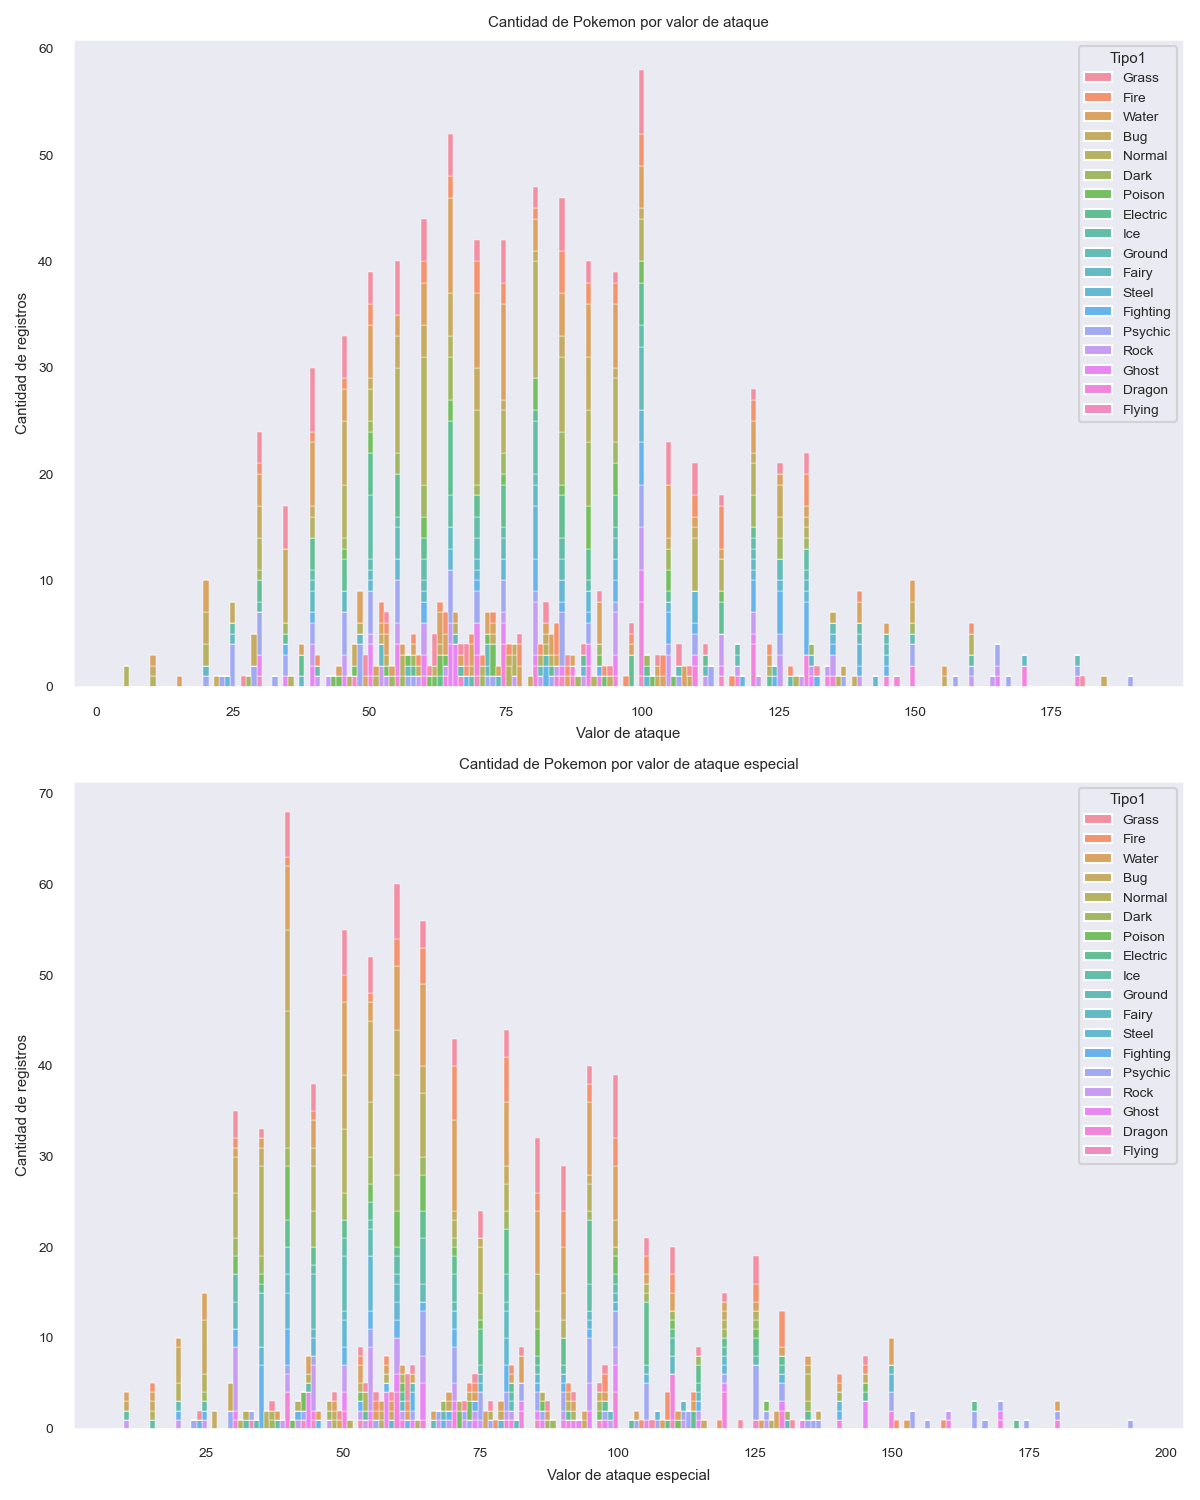

##### Frecuencia con que se presentan combinaciones de Pokemon en los equipos observados en las instancias competitivas.
Este tipo de análisis permite avanzar hacia el desarrollo de una herramienta más compleja que permita evaluar el potencial de posibles equipos a los que el usuario podrá enfrentarse, partiendo de un Pokemon que se sabe que va a estar en dicho equipo.

Dropdown(description='Pokemon:', options=('Abomasnow', 'Accelgor', 'Aegislash Shield Forme', 'Aerodactyl', 'Al…

<IPython.core.display.Javascript object>


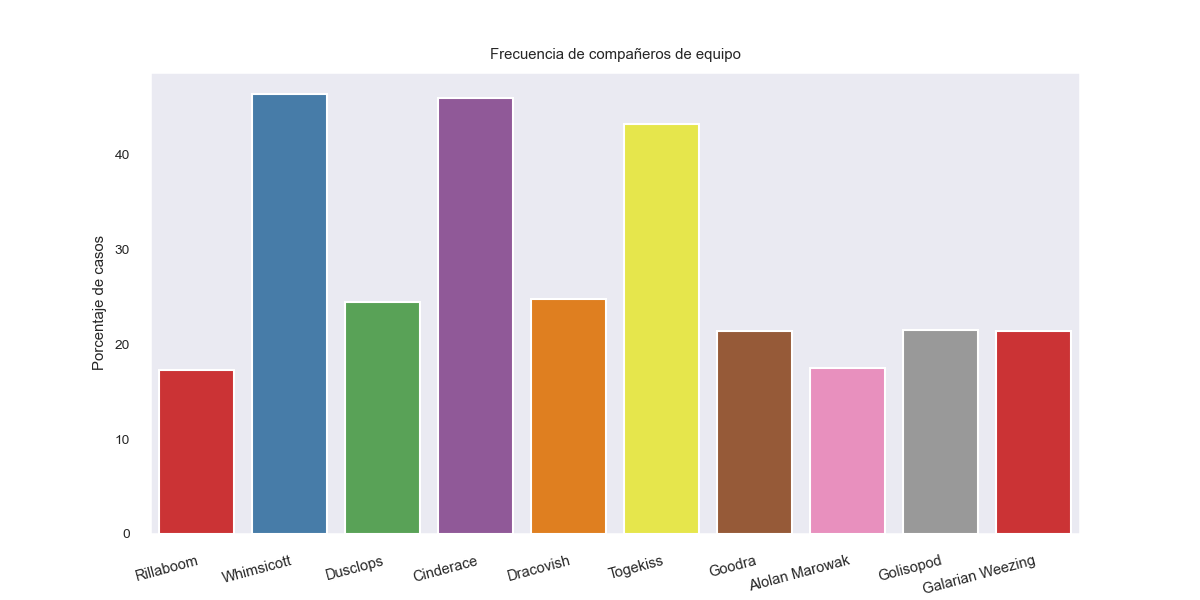

##### Posibles miembros de eqipo que se pueden presentar a partir de un Pokemon en particular.
Como se mencionó anteriormente, de forma recursiva se puede establecer posibles equipos, basados en la información disponible respecto a la frecuencia con que se puede encontrar en instancias competitivas un Pokemon con otro.

Dropdown(description='Pokemon:', options=('Abomasnow', 'Abra', 'Absol', 'Accelgor', 'Aegislash Blade Form', 'A…

Output(layout=Layout(border='1px solid black'))

##### Variación de características por tipo de Pokemon.
Otro análisis praticular que se puede realizar, es sobre los posibles valores de Ataque, Defensa, Ataque especial, Defensa especial, Vida y Velocidad que puede tener cada Pokemon, en vista de que los resultados de las batallas se encontrarán fuertemente relacionados con los mismos.

##### Concluciones
Si bien los análisis realizados anteriormente pueden resultar interesantes, puede notarse que la información que puede obtenerse de estos no resultan del todo útil para avanzar directamente sobre los objetivos planteados. Será necesario cruzar estos datos con el resto de datos disponibles para buscar información de relevancia.

#### Análisis bivariado.
Avanzando sobre el análisis de los distintos datos, se enfrenta un análisis bivariado, buscan encontrar relaciones que puedan ser de relevancia al momento de buscar e implementar un modelo adecuado para los objetivos planteados en este proyecto.

##### Análisis estadísticos de atque y defensa, por tipo de Pokemon. 
Este análisis básico permite tomar decisiones iniciales al momento de elegir los tipos de cada Pokemon, en pos de armar equipos más ofensivos o defensivos, segun los gustos del jugador.

Un siguiente análisis podrá incluir información de las ventajas y desventajas de tipo, para analizar qué ataques podrían afectar más a cada tipo de Pokemon.

<IPython.core.display.Javascript object>


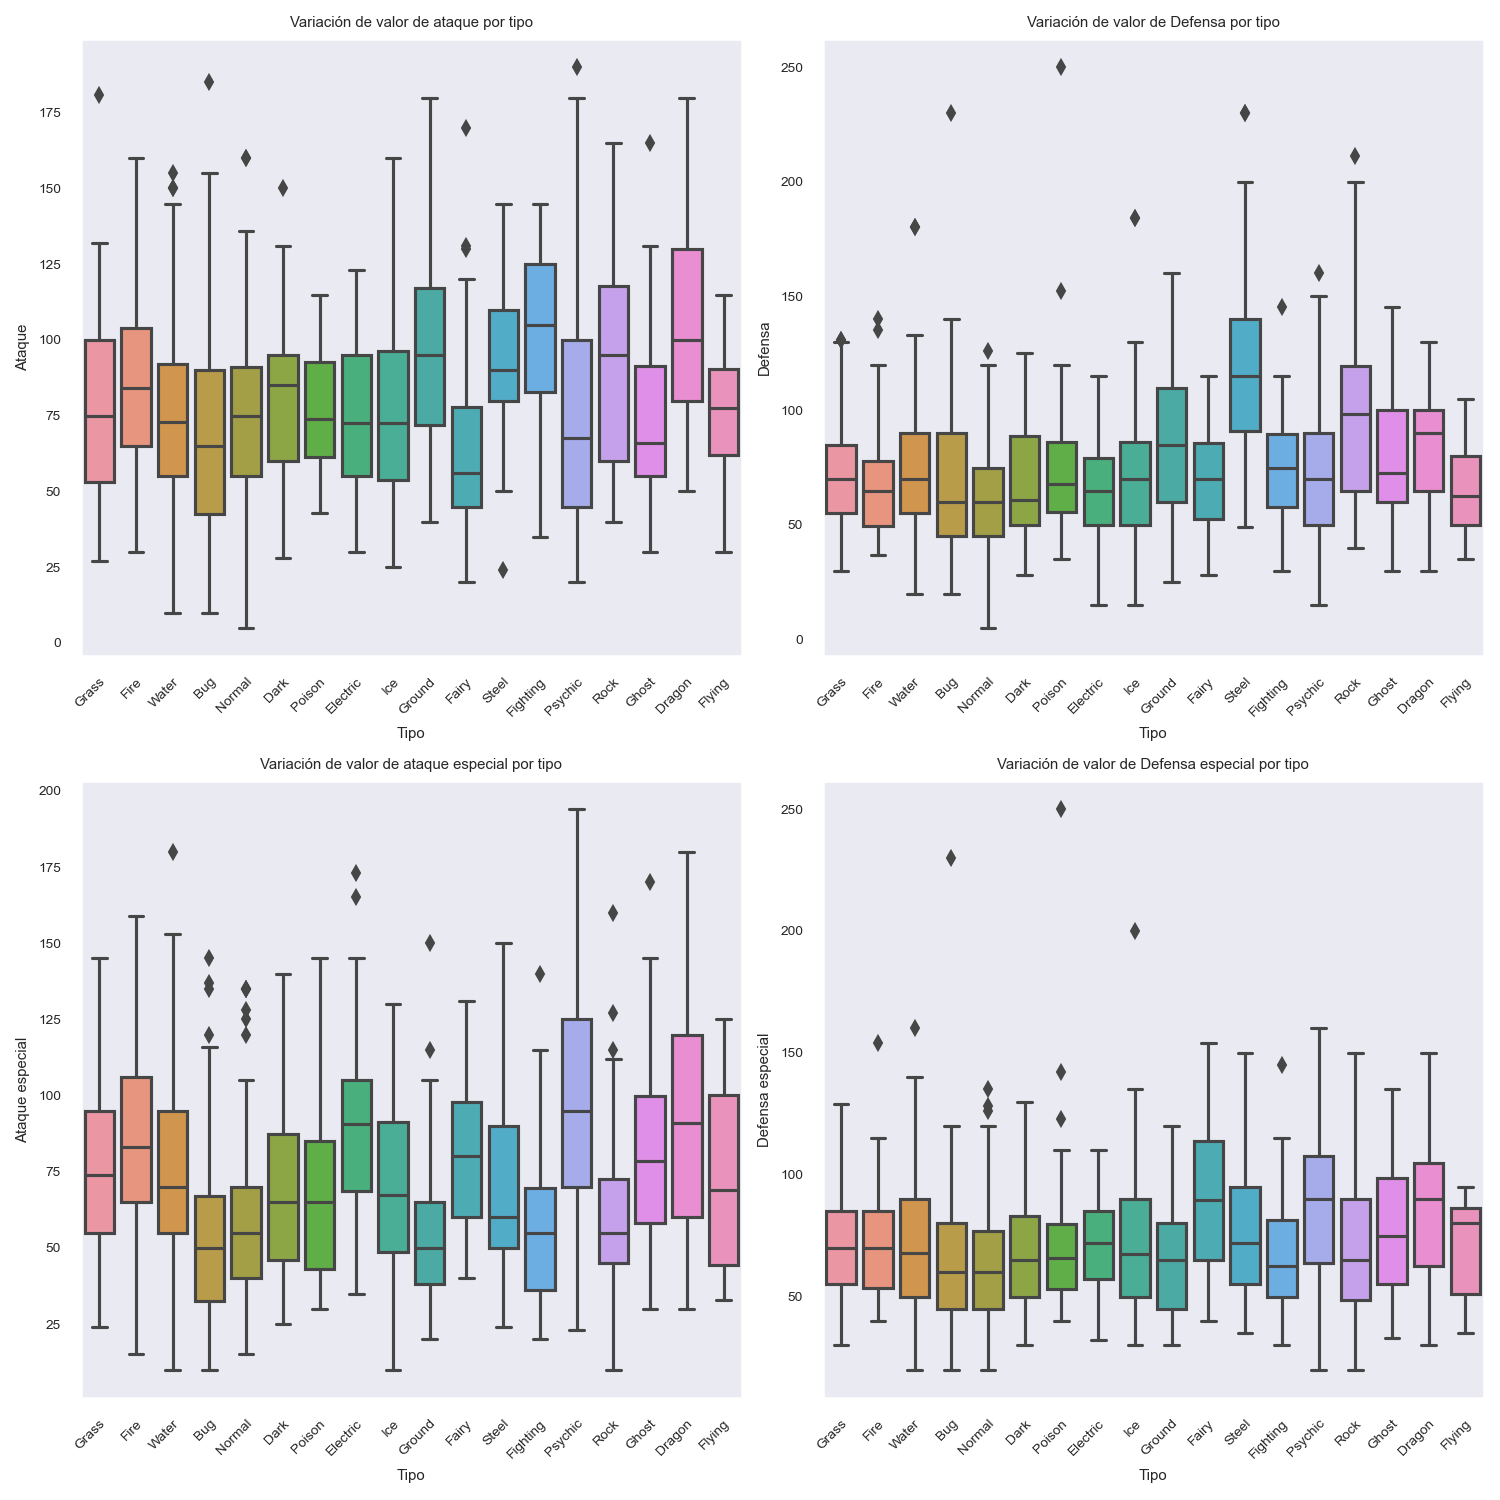

##### Análisis de las posibles combinaciones de tipo que se pueden encontrar.
Esto permitiendo realizar análisis de probabilidad de tipos frente a los cuales enfrentarse, al momento de competir con jugadores poco conocidos, o que acostumbren a sorprender con equipos nuevos.

Nuevamente puede proyectarse un análisis más complejo incluyendo ventajas y debilidades, asociando los tipos de ataques que puede aprender cada tipo de Pokemon, y así poder identificar los Pokemon más utiles que posean combinaciones Tipos de Pokemon/Tipos de ataque, que permitan contrarrestar las debilidades y potenciar las ventajas.

<IPython.core.display.Javascript object>


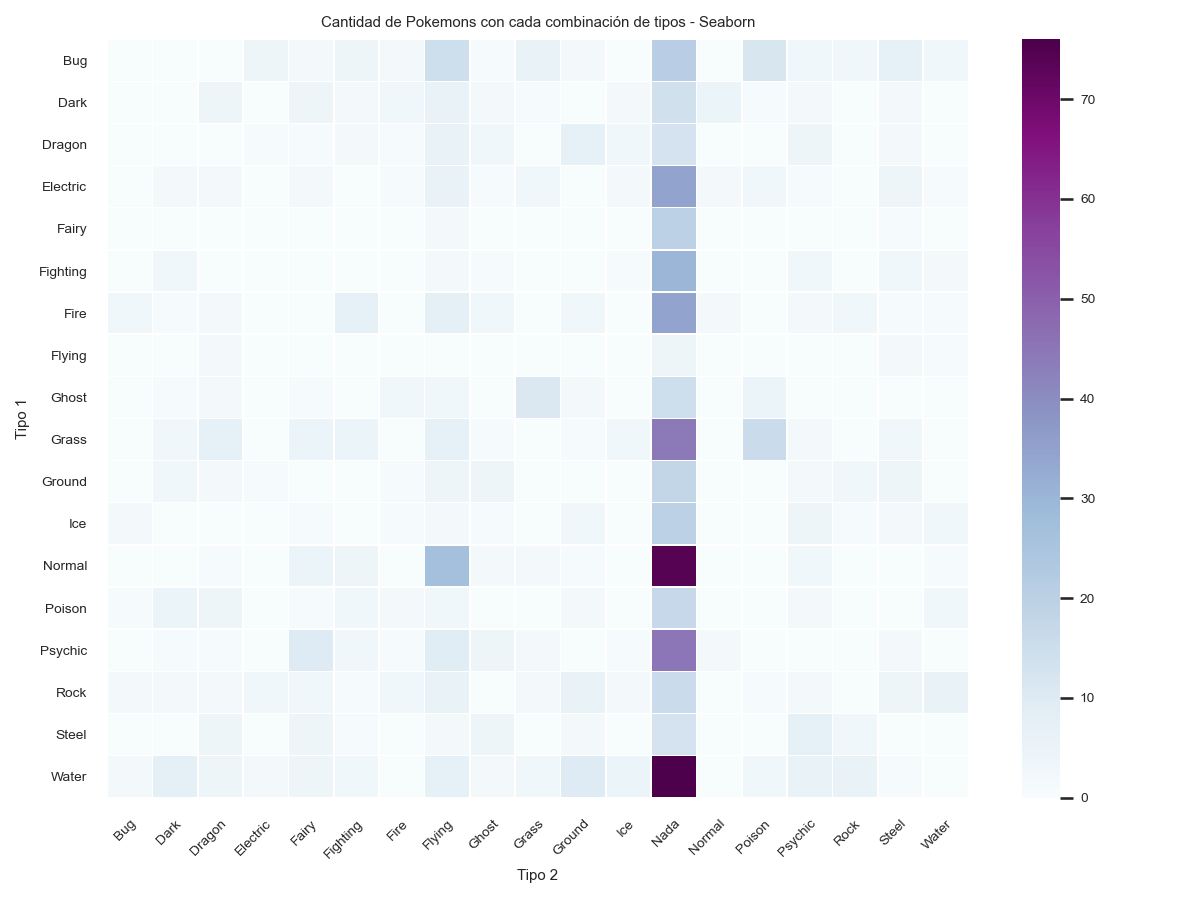

##### Análisis de correlación entre carácterísticas y porcentaje de victoria mediante *Z-score*
Inicialmente se busca si existe relación entre las distintas caracterísitcas de un Pokemon y el porcentaje de victorias del mismo, basados en una muestra de 50000 caso de combates 1 vs 1.

<IPython.core.display.Javascript object>


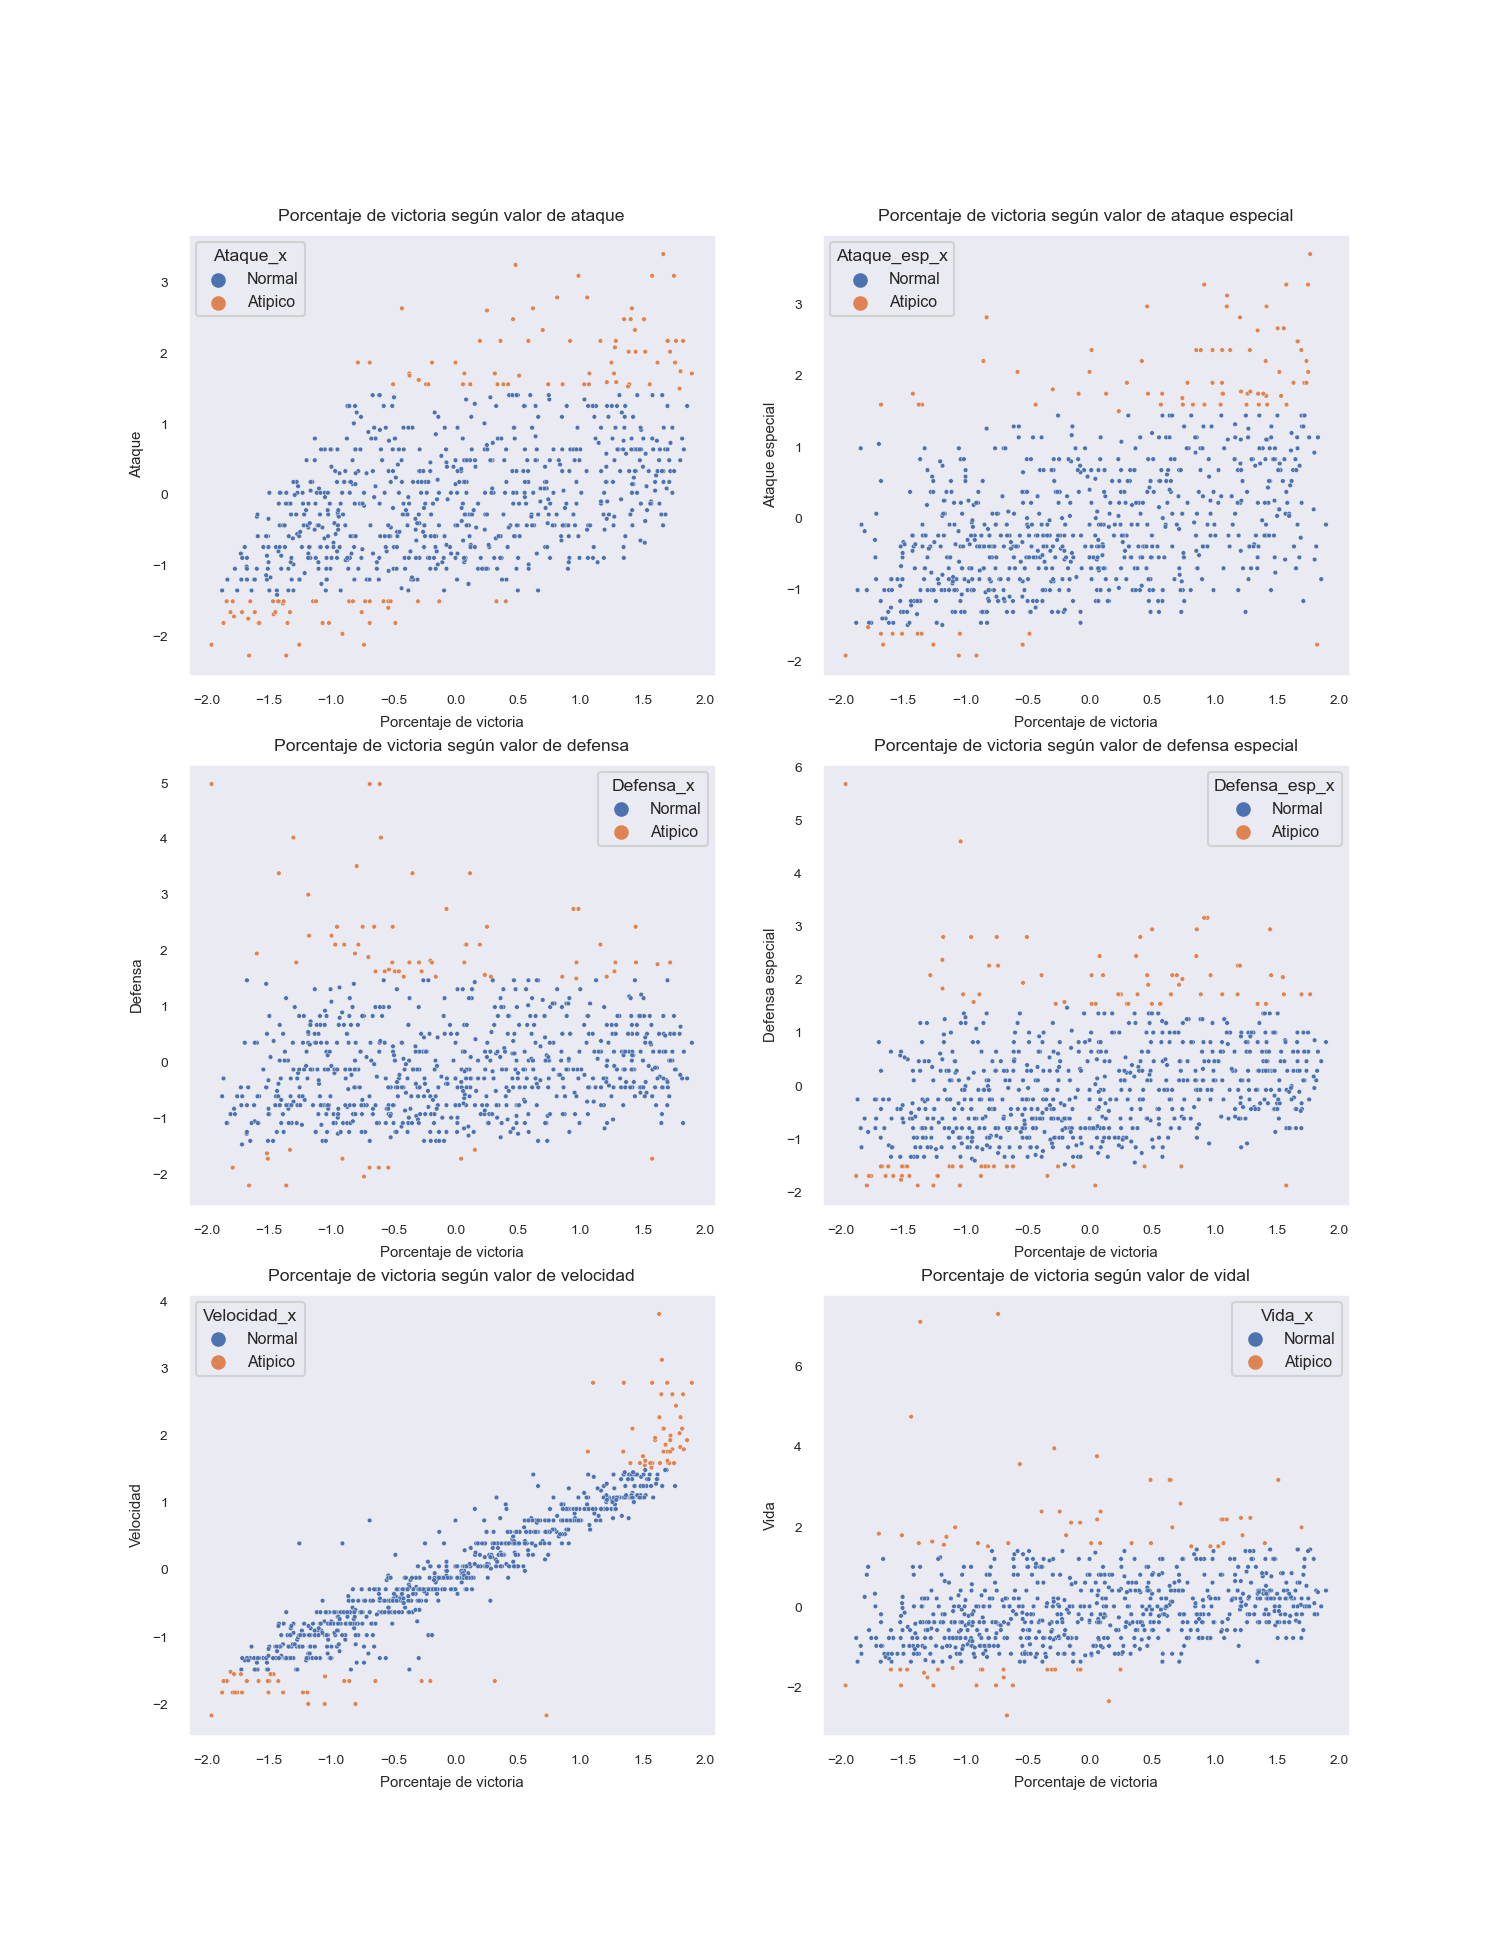

Puede observarse que, en un principio, solo existe correlación entre la velocidad y el porcentaje de victoria, dado que para el resto de las características no puede observarse una tendencia marcada.

##### Visualización de correlaciones mediante *heatmap*
El siguiente paso es buscar la correlación entre las varialbes.
Para esto se creó un heatmap que cruzara la correlación de cada variable con el resto.

<IPython.core.display.Javascript object>


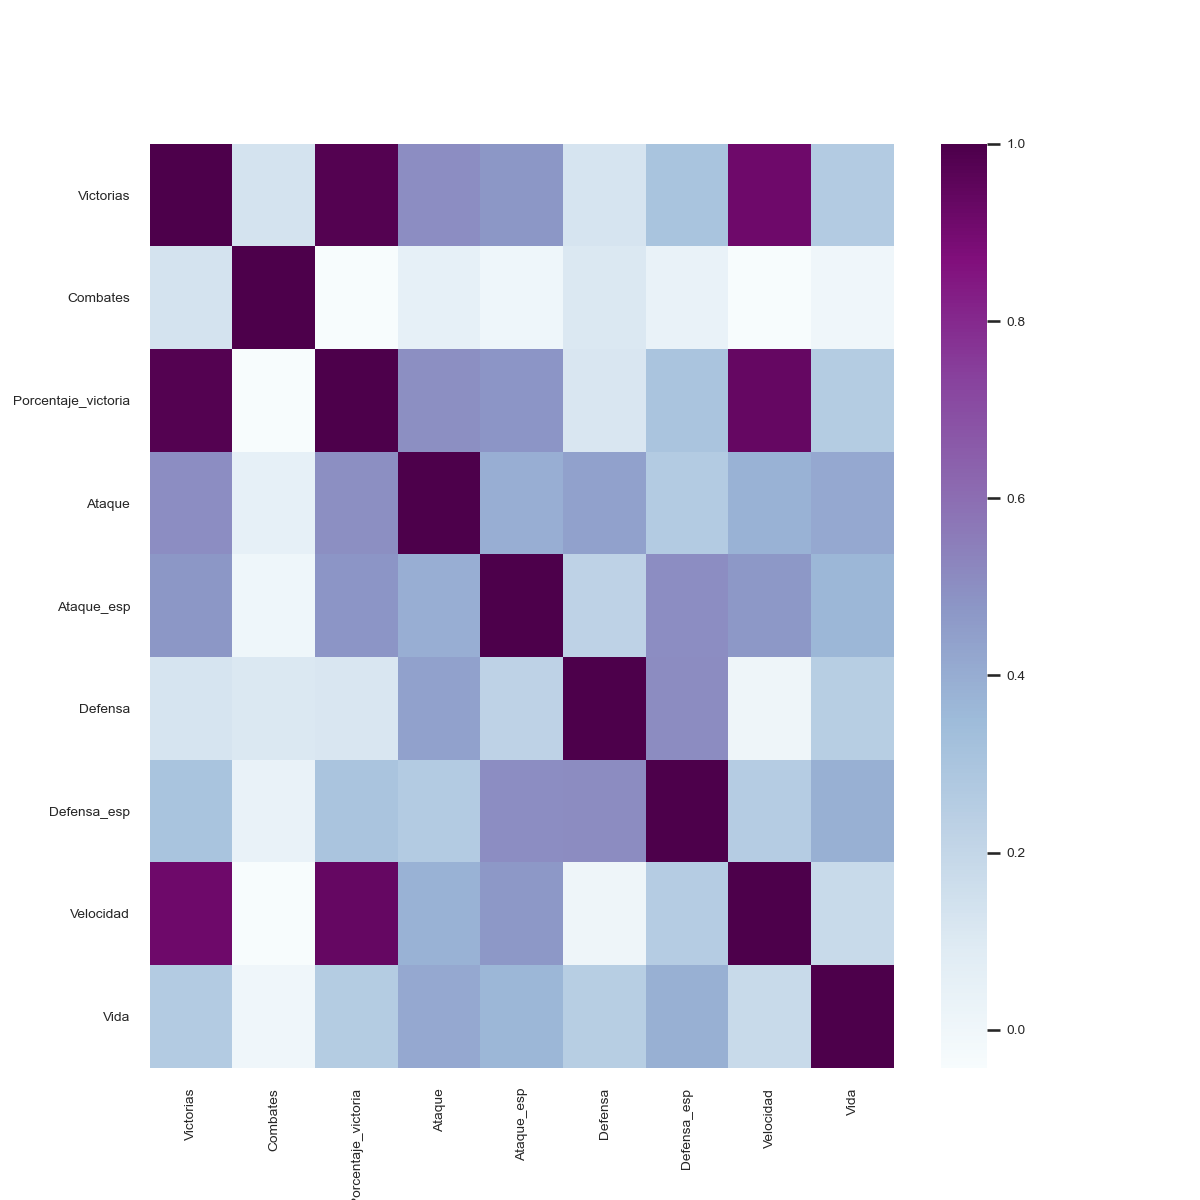

Del gráfico anterior se desprende tres observaciones principales:
    
    * La velocidad está fuertemente relacionada con las probabilidades de victoria.
    * Los valores de ataque y ataque especial, tienen influencia sobre el resultado de la batalla.
    * Los valores de defensa y defensa especial no tendrían tanta influencia como podría pensarse en un principio.
    
##### Concluciones
Como se ha ido observando a lo largo del análisis bivariado, se puede concluir que, según los datos disponibles, la característica más relevante para analizar las probabilidades de victoria resulta ser la velicidad, mientras que la defensa y defensa especial resulta casi insignificantes para analizar una posbile victoria.

#### Análisis multivariado.
Finalmente se analizará conjuntos más complejos de variables, siempre buscando encontrar posibles patrones, desviaciones, outlayers y cualquier otro evento que quede por fuera de lo esperado de forma intuitiva y por el conocimiento de la temática abordada.

##### Herramienta interactiva para análisis comparativos de las careacterísticas de cada Pokemon, afectadas por las posibles naturalezas asociadas los mismos.

Esta herramienta puede resultar útil para decidir los Pokemon que formarán parte de un equipo, una vez establecida la importanca de cada característica sobre la selección.

Una siguiente estapa a desarrollar podrá incluir los posibles daños ocasionados por los distintos ataques, asociándolos al Pokemon, sus características, y el tipo de Pokemon con el que se enfrente.

<IPython.core.display.Javascript object>


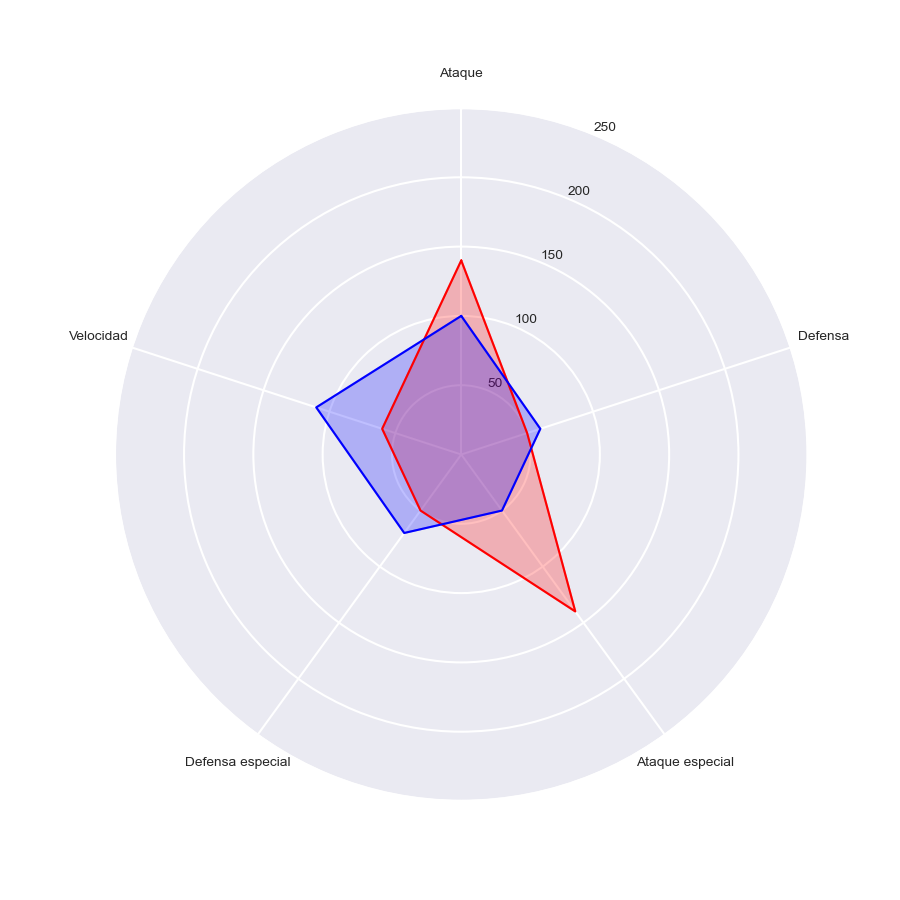

##### Disperción de combinaciones Ataque/Defensa y Ataque Especial/Defensa Especial de acuerdo al tipo de Pokemon.

Nuevamente, una vez definidas las características de mayor relevancia, este tipo de análisis permitría observar y detectar posibles tendencias de acuerdo a los tipos y generaciones de Pokemon, permitiendo decidir o proyectar la precencia de cada uno en los equipos competitivos.

Dropdown(description='Tipo:', options=('Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flyi…

<IPython.core.display.Javascript object>


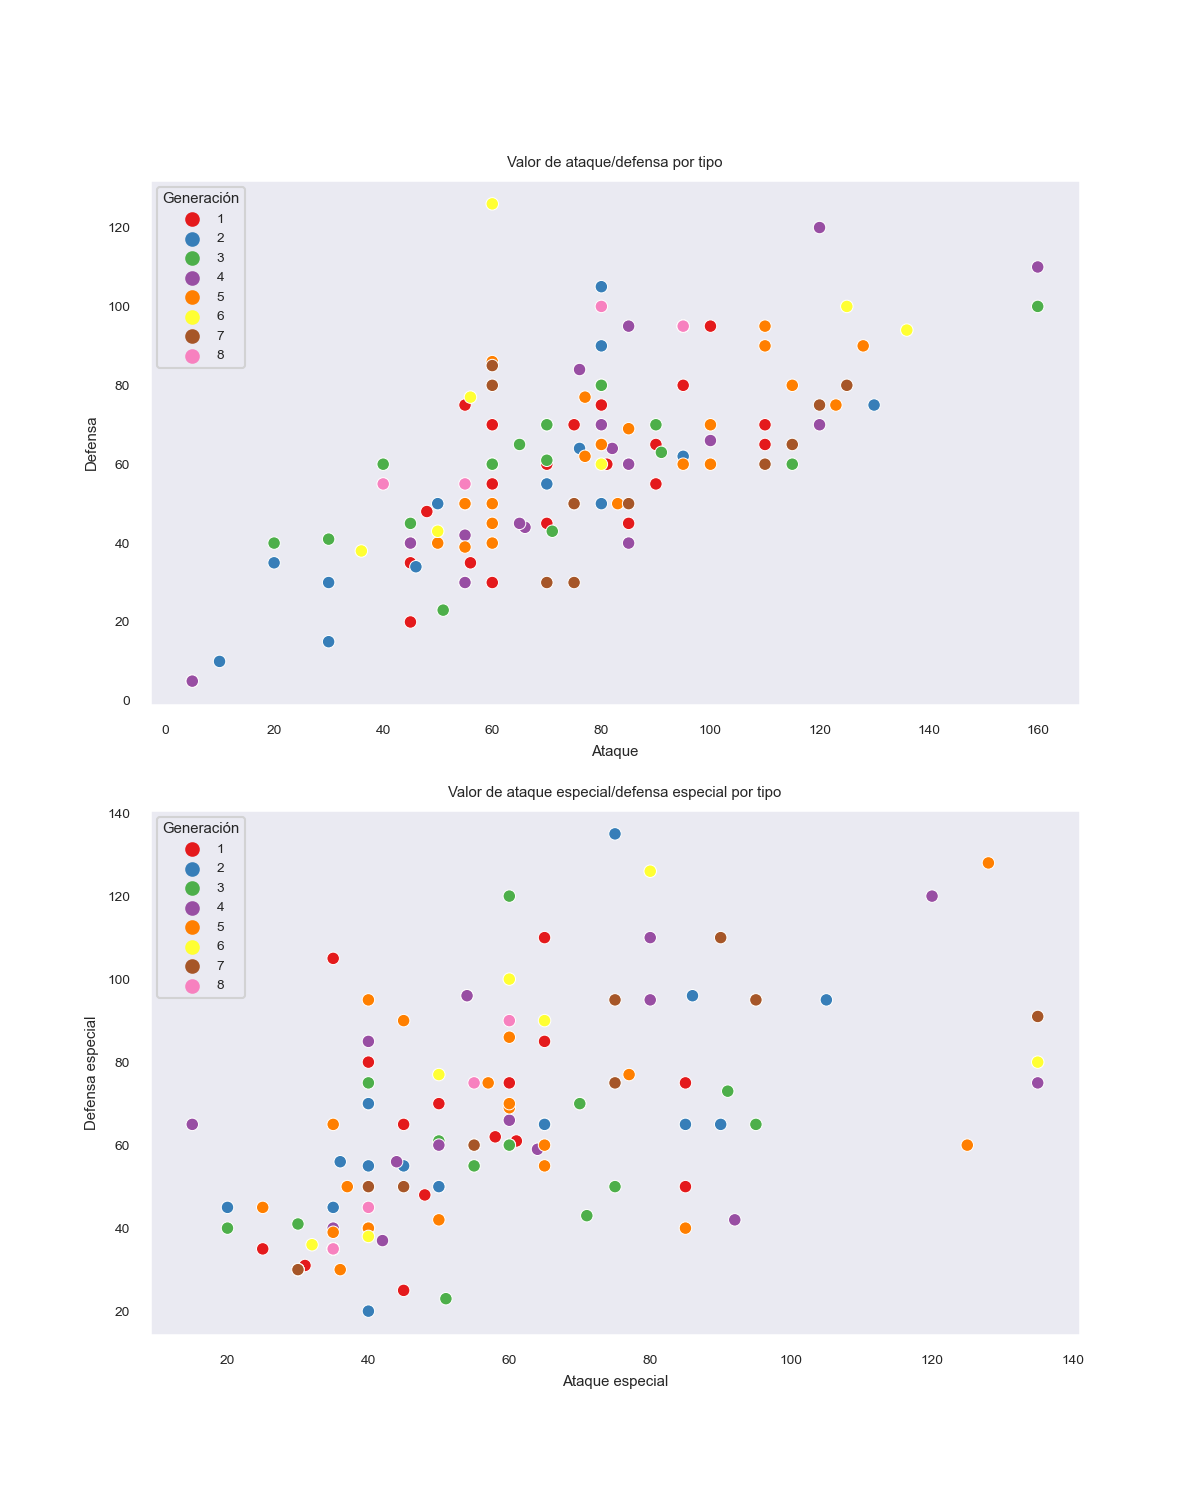

##### Distribución de la diferencia de características entre los Pokemon combatientes.
Para esto se diagramó un histograma con la diferencia presente entre los Pokemon enfrentados en cada caso.

<IPython.core.display.Javascript object>


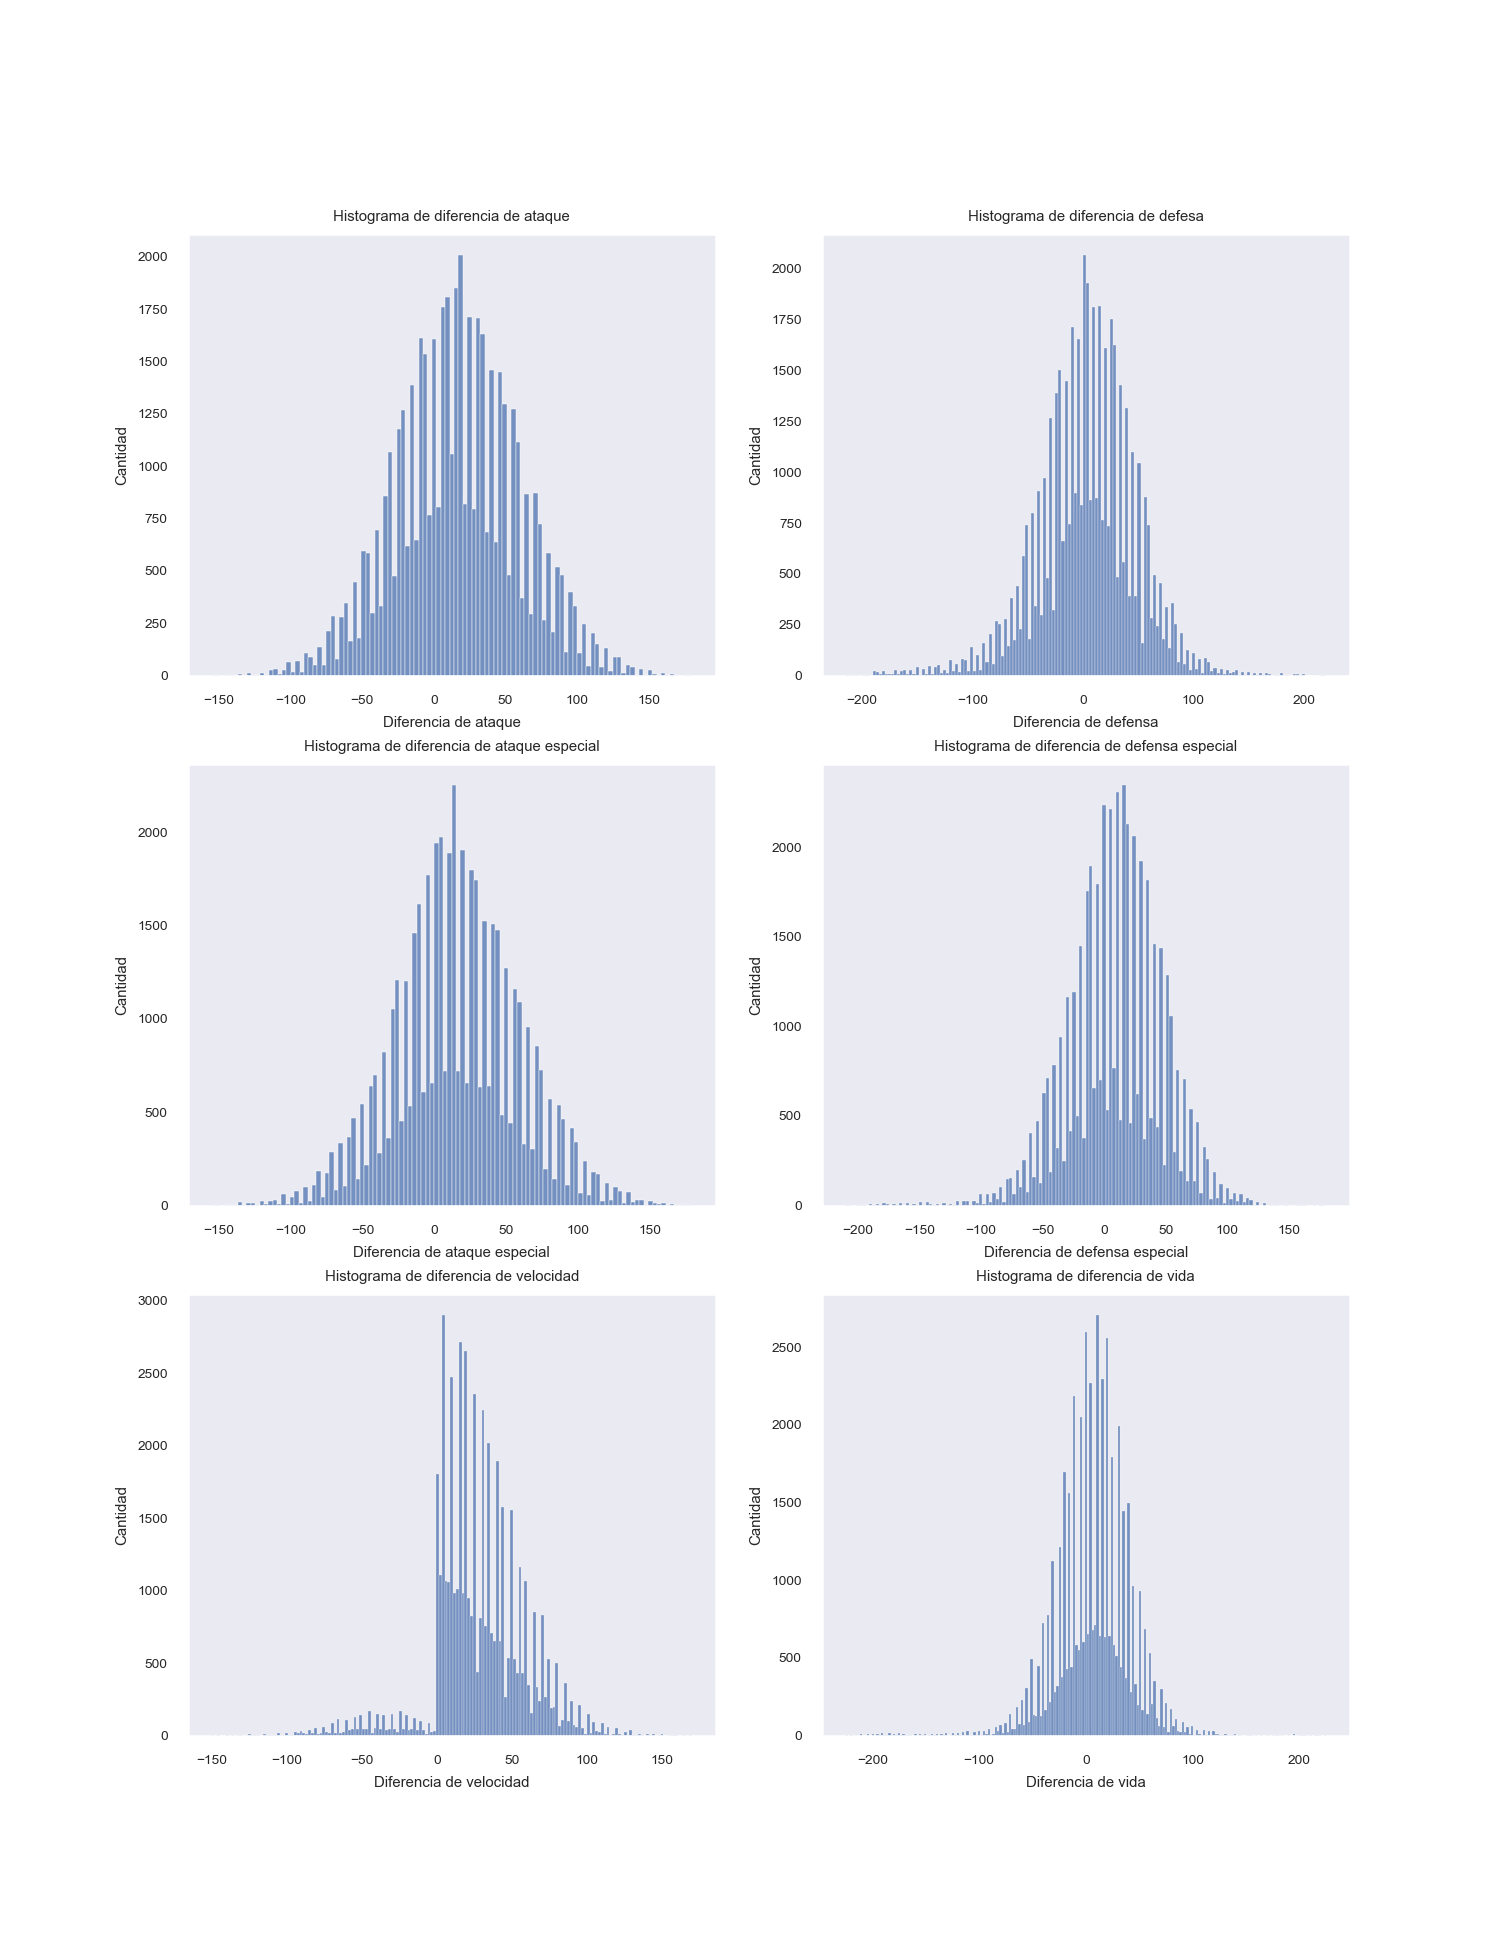

Considerando que los valores positivos corresponde a un mayor valor de la característica en favor del ganador, mientras que los valores negativos implica un mayor valor de la caracteristica en favor del perdedor.

Este análisis refuerza las observaciones del *heatmap*, dado que a excepción del histograma de velocidad, la distribución las demás variables es simétrica en torno a cero, aproximadamente.

##### Conclución
Luego de los distintos análisis hasta este punto, la principal conclución que puede sacarse es que de las seis características disponibles para cada Pokemon, la velocidad es la que está más ligada a las probabilidades de victoria.

#### Análisis del modelado
En la siguiente sección se presentará el análisis de los posibles modelos a implementar en este estudio.

En una primera instancia se analizará el ajuste de cada variable, respecto al porcentaje de victorias.

                            OLS Regression Results                            
Dep. Variable:                 Ataque   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     264.5
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           1.90e-51
Time:                        14:18:20   Log-Likelihood:                -3729.5
No. Observations:                 784   AIC:                             7463.
Df Residuals:                     782   BIC:                             7472.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              46.8781    

Nuevamente puede observarse, al analizar los valores de **r cuadrado**, que la caracterísitica que mejor ajusta a una regresión lineal, respecto al porcentaje de victorias, es la velicidad de cada Pokemon, lo que podría indicar una correlación entre estos valores.

### Analisis de posibles modelos a implementar

Del análisis de los datos, y los objetivos máximos planteados, la mejor forma de obtener una herramienta util sería utilzar modelos de **aprendizaje por refuerzo**, donde se podría utilizar en una primera instancia, un algoritmo de *fuerza bruta* si se realiza análisis 1v1, donde sólo estarían implicadas las características del Pokemon y el objeto que el mismo lleve. En caso de buscar analizar combates completos, con equipos de 6 Pokemon, la cantidad de combinaciones sería demasiado grande por lo que debería buscarse un algoritmo más complejos como *Q-Learning*.

De todas formas se pueden obtener resultados un poco menos ambiciosos, generando, por ejemplo, *árboles de decisión* en primera instancia para ofrecer de forma gráfica la incidencia de cada caracterísitica en la desición de pokemon al enfrentar 1vs1, o de forma un poco más compleja y eficiente *random forest* incluido en una herramiente que a partir de él muestre directamente las mejores opciones para enfrentar un Pokemon.

A fin de comenzar a realizar pruebas sobre los modelos antes mencionados, se implementó un *arbol de decisiones* utilizando la información de las características de cada Pokemon.

<IPython.core.display.Javascript object>


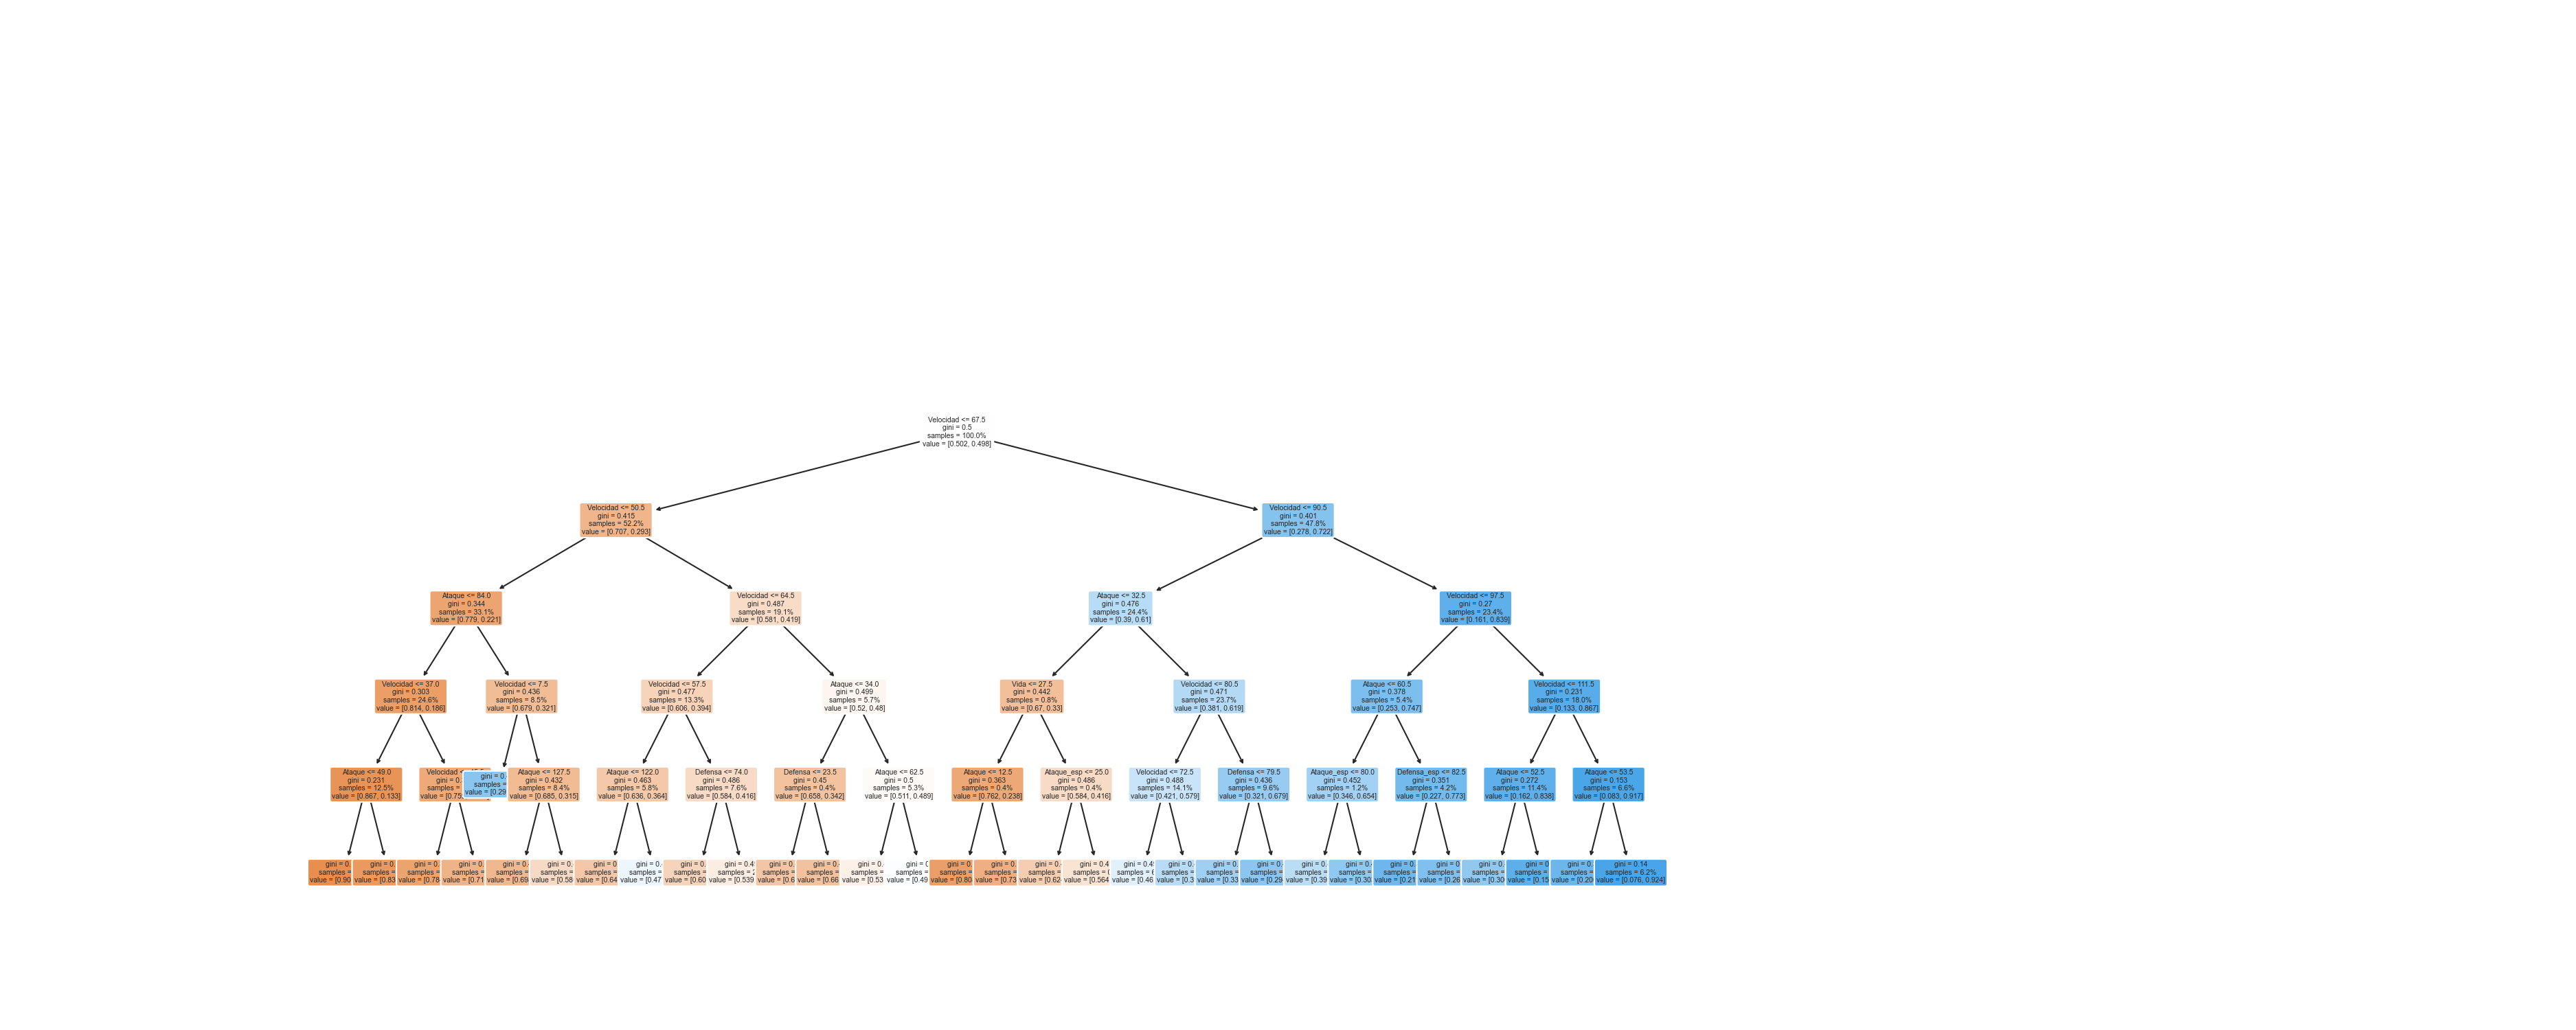

Accuracy: 0.7142333333333334


<IPython.core.display.Javascript object>


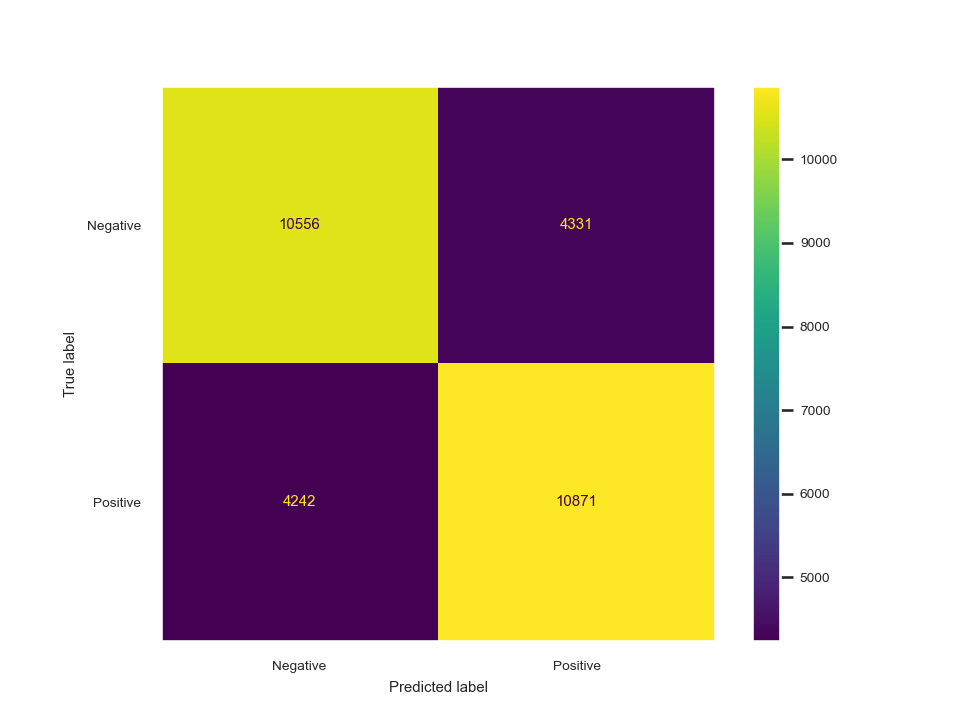

              precision    recall  f1-score   support

           0       0.71      0.71      0.71     14887
           1       0.72      0.72      0.72     15113

    accuracy                           0.71     30000
   macro avg       0.71      0.71      0.71     30000
weighted avg       0.71      0.71      0.71     30000



Si bien la precisión del modelo es superior a 0.5, no es buena, por lo que debería analizarse y probar dejando fuera algunas variables que pueden no ser de importancia.
Se puede observar además, que el modelo pone en primer lugar la característica *velocidad*, acorde a lo que se había analizado previamente.

### Conclusiones iniciales
Se puede destacar que se obtuvo un modelo que permite, en primera instancia, decidir cuál sería el mejor Pokemón para enfrentarse a otro basado en sus característica.

Aún así, la presición del modelo no es buena, y los resultados no son los esperados.

Considerar la característica de *velocidad* como la de mayor importancia, sobre los valores de *ataque* o *defensa*, puede ser un indicativo de que los datos utilizados no son los adecuados, o que alguna de las variables está generando ruido sobre el resultado.

Luego de un análisis detallado de detaset original, podría concluirse que el problema está en que cada Pokemon atacará principalemnte con *ataques físicos* o *ataques especiales*, pero no ambos, por lo que análizar estas variables en conjunto puede ser desacertado.

Así mismo, en dataset no dispone del set de movimientos utilizados, por los que se están dejando de lado los indicadores de ventaja por tipo, los cuales pueden ser de gran importancia y marcar una diferencia en las victorias.

Para mejorar esto, se deberá buscar información más detallada, donde además de los Pokemones combatientes y el resultado, se establezca el tipo de ataques utilizados y el tipo de daño, de esta forma segmentar y generar dos árboles de decisión separados, que contemplen las ventajas de tipo, y permitan visualizar por un lado los combates con tipo de daño *"ataque"* y por el otro tipo de daño *"ataque especial"*.

In [12]:
# Para poder ver e interactuar con el informe debe ejecutarse esta celda.
proyecto(pk, moves, nat, pwp, eff, m_learn, wins, ganadores, ganadores_dif)